In [5]:
%%capture
!pip install optuna
!pip install catboost
!pip install xgboost




# 1 | Importing Required Libraries & DataSource




In [7]:
# Libraries for Data Manipulation
import pandas as pd
import numpy as np

import gc

# Libraries for Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from scipy.stats import skew
sns.set(style="white", font_scale=1.5)
sns.set(rc={"axes.facecolor":"#FFFAF0", "figure.facecolor":"#FFFAF0"})
sns.set_context("poster", font_scale=.7)
import matplotlib.ticker as ticker

# Libraries to Handle Warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries for Statistical Analysis
from scipy import stats
from scipy.stats import chi2, chi2_contingency

# Setting Display Options
pd.set_option("display.max.columns", None)

#for hypertuning
import optuna

# Machine Learning Algorithms
from sklearn.preprocessing import PowerTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    ExtraTreesClassifier
)
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import joblib

# Library for Cross-Validation
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV

# Model Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,silhouette_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

# Data Source
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))




# Load and Inspect Dataset




In [31]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
original_df = pd.read_csv('data.csv', sep=';')

In [171]:
train_df.head()

id  Marital status  Application mode  Application order  Course  \
0   0               1                 1                  1    9238   
1   1               1                17                  1    9238   
2   2               1                17                  2    9254   
3   3               1                 1                  3    9500   
4   4               1                 1                  2    9500   

   Daytime/evening attendance  Previous qualification  \
0                           1                       1   
1                           1                       1   
2                           1                       1   
3                           1                       1   
4                           1                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           126.0            1                       1   
1                           125.0            1                      19   
2                           137.0            1                       3   
3                           131.0            1                      19   
4                           132.0            1                      19   

   Father's qualification  Mother's occupation  Father's occupation  \
0                      19                    5                    5   
1                      19                    9                    9   
2                      19                    2                    3   
3                       3                    3                    2   
4                      37                    4                    9   

   Admission grade  Displaced  Educational special needs  Debtor  \
0            122.6          0                          0       0   
1            119.8          1                          0       0   
2            144.7          0                          0       0   
3            126.1          1                          0       0   
4            120.1          1                          0       0   

   Tuition fees up to date  Gender  Scholarship holder  Age at enrollment  \
0                        1       0                   1                 18   
1                        1       0                   0                 18   
2                        1       1                   0                 18   
3                        1       0                   1                 18   
4                        1       0                   0                 18   

   International  Curricular units 1st sem (credited)  \
0              0                                    0   
1              0                                    0   
2              0                                    0   
3              0                                    0   
4              0                                    0   

   Curricular units 1st sem (enrolled)  \
0                                    6   
1                                    6   
2                                    6   
3                                    7   
4                                    7   

   Curricular units 1st sem (evaluations)  \
0                                       6   
1                                       8   
2                                       0   
3                                       9   
4                                      12   

   Curricular units 1st sem (approved)  Curricular units 1st sem (grade)  \
0                                    6                         14.500000   
1                                    4                         11.600000   
2                                    0                          0.000000   
3                                    7                         12.591250   
4                                    6                         12.933333   

   Curricular units 1st sem (without evaluations)  \
0                                               0   
1                                               0   
2           

In [ ]:
original_df.head()

In [ ]:
test_df.head()

In [18]:
print("train_df columns:", train_df.columns)
print('-'* 80)
# print("original_df columns:", original_df.columns)


train_df columns: Index(['id', 'Marital status', 'Application mode', 'Application order',
       'Course', 'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
      

In [32]:
# Standardize column names by stripping leading/trailing spaces
train_df.columns = train_df.columns.str.strip()
original_df.columns = original_df.columns.str.strip()

In [42]:
# Find differences in columns
train_columns = set(train_df.columns)
original_columns = set(original_df.columns)

In [43]:
# Columns in train_df but not in original_df
only_in_train = train_columns - original_columns
only_in_train

{'id'}

In [44]:
# Columns in original_df but not in train_df
only_in_original = original_columns - train_columns
only_in_original

set()

## Description of the features in the student success dataset features:

1. **id**: Unique identifier for each student.
2. **Marital status**: Marital status of the student (e.g., single, married).
3. **Application mode**: Mode of application (e.g., online, offline).
4. **Application order**: Order in which the application was submitted.
5. **Course**: The course in which the student is enrolled.
6. **Daytime/evening attendance**: Whether the student attends classes during the day or evening.
7. **Previous qualification**: The previous qualification level of the student (e.g., high school, diploma).
8. **Previous qualification (grade)**: Grade achieved in the previous qualification.
9. **Nacionality**: Nationality of the student.
10. **Mother's qualification**: Educational qualification of the student's mother.
11. **Father's qualification**: Educational qualification of the student's father.
12. **Mother's occupation**: Occupation of the student's mother.
13. **Father's occupation**: Occupation of the student's father.
14. **Admission grade**: Grade achieved at the time of admission.
15. **Displaced**: Whether the student has been displaced from their original place of residence.
16. **Educational special needs**: Whether the student has any special educational needs.
17. **Debtor**: Whether the student has any outstanding debts.
18. **Tuition fees up to date**: Whether the student's tuition fees are up to date.
19. **Gender**: Gender of the student (e.g., male, female, non-binary).
20. **Scholarship holder**: Whether the student is a scholarship holder.
21. **Age at enrollment**: Age of the student at the time of enrollment.
22. **International**: Whether the student is an international student.
23. **Curricular units 1st sem (credited)**: Number of curricular units credited in the first semester.
24. **Curricular units 1st sem (enrolled)**: Number of curricular units enrolled in the first semester.
25. **Curricular units 1st sem (evaluations)**: Number of evaluations in the first semester.
26. **Curricular units 1st sem (approved)**: Number of curricular units approved in the first semester.
27. **Curricular units 1st sem (grade)**: Grade of the curricular units in the first semester.
28. **Curricular units 1st sem (without evaluations)**: Number of curricular units without evaluations in the first semester.
29. **Curricular units 2nd sem (credited)**: Number of curricular units credited in the second semester.
30. **Curricular units 2nd sem (enrolled)**: Number of curricular units enrolled in the second semester.
31. **Curricular units 2nd sem (evaluations)**: Number of evaluations in the second semester.
32. **Curricular units 2nd sem (approved)**: Number of curricular units approved in the second semester.
33. **Curricular units 2nd sem (grade)**: Grade of the curricular units in the second semester.
34. **Curricular units 2nd sem (without evaluations)**: Number of curricular units without evaluations in the second semester.
35. **Unemployment rate**: Unemployment rate at the time of enrollment.
36. **Inflation rate**: Inflation rate at the time of enrollment.
37. **GDP**: Gross Domestic Product at the time of enrollment.
38. **Target**: The target variable indicating the success of the student (e.g., binary outcome such as success or failure).m

Understanding these features and the target variable is crucial for building predictive models and designing effective student success prediction.

=>


# 2 | Data Exploration




<a id='2.1'></a>
#### 2.1. Computing Dimension of Dataset

In [ ]:
print("dataset shape: ",train_df.shape)

In [75]:
print("dataset shape: ",original_df.shape)

dataset shape:  (4424, 37)


In [24]:
print("dataset shape: ",test_df.shape)

dataset shape:  (51012, 37)


In [33]:
train_df = pd.concat([train_df,original_df],axis = 0)

In [7]:
# after concating the shape of df
print("dataset shape: ",train_df.shape)

dataset shape:  (80942, 38)


<a id='2.2'></a>
#### 2.2. Statistical Summary of Dataset

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85366 entries, 0 to 4423
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              85366 non-null  int64  
 1   Marital status                                  85366 non-null  int64  
 2   Application mode                                85366 non-null  int64  
 3   Application order                               85366 non-null  int64  
 4   Course                                          85366 non-null  int64  
 5   Daytime/evening attendance                      85366 non-null  int64  
 6   Previous qualification                          85366 non-null  int64  
 7   Previous qualification (grade)                  85366 non-null  float64
 8   Nacionality                                     85366 non-null  int64  
 9   Mother's qualification                       

In [34]:
# Identify the data types of columns
column_data_types = train_df.dtypes

# Count the numerical and categorical columns
numerical_count = 0
categorical_count = 0

for column_name, data_type in column_data_types.items():
    if np.issubdtype(data_type, np.number):
        numerical_count += 1
    else:
        categorical_count += 1

# Print the counts
print(f"There are {numerical_count} Numerical Columns in dataset")
print(f"There are {categorical_count} Categorical Columns in dataset")

There are 37 Numerical Columns in dataset
There are 1 Categorical Columns in dataset


<a id='2.3'></a>
#### 2.3. Dropping Attritbutes which doesn't imply any meaningful insights in our analysis.

In [35]:
# saving id to use for submission work at end
id = test_df['id']

In [213]:
print(id)

0         76518
1         76519
2         76520
3         76521
4         76522
          ...  
51007    127525
51008    127526
51009    127527
51010    127528
51011    127529
Name: id, Length: 51012, dtype: int64


In [36]:
cols = ["id"]
train_df.drop(columns=cols, inplace=True)
test_df.drop(columns=cols, inplace=True)

<a id='2.4'></a>
#### 2.4. Checking if There's Any Duplicate Records.

In [37]:
print("Duplicates in Dataset: ",train_df.duplicated().sum())

Duplicates in Dataset:  0


<a id='2.5'></a>
#### 2.5. Computing Total No. of Missing Values and the Percentage of Missing Values

In [38]:
missing_data = train_df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_data["% of Missing Values"] = round((missing_data["Total No. of Missing Values"]/len(train_df))*100,2)
missing_data

Total No. of Missing Values  \
Marital status                                                            0   
Application mode                                                          0   
Application order                                                         0   
Course                                                                    0   
Daytime/evening attendance                                                0   
Previous qualification                                                    0   
Previous qualification (grade)                                            0   
Nacionality                                                               0   
Mother's qualification                                                    0   
Father's qualification                                                    0   
Mother's occupation                                                       0   
Father's occupation                                                       0   
Admission grade                                                           0   
Displaced                                                                 0   
Educational special needs                                                 0   
Debtor                                                                    0   
Tuition fees up to date                                                   0   
Gender                                                                    0   
Scholarship holder                                                        0   
Age at enrollment                                                         0   
International                                                             0   
Curricular units 1st sem (credited)                                       0   
Curricular units 1st sem (enrolled)                                       0   
Curricular units 1st sem (evaluations)                                    0   
Curricular units 1st sem (approved)                                       0   
Curricular units 1st sem (grade)                                          0   
Curricular units 1st sem (without evaluations)                            0   
Curricular units 2nd sem (credited)                                       0   
Curricular units 2nd sem (enrolled)                                       0   
Curricular units 2nd sem (evaluations)                                    0   
Curricular units 2nd sem (approved)                                       0   
Curricular units 2nd sem (grade)                                          0   
Curricular units 2nd sem (without evaluations)                            0   
Unemployment rate                                                         0   
Inflation rate                                                            0   
GDP                                                                       0   
Target                                                                    0   

                                                % of Missing Values  
Marital status                                                  0.0  
Application mode                                                0.0  
Application order                                               0.0  
Course                                                          0.0  
Daytime/evening attendance                                      0.0  
Previous qualification                                          0.0  
Previous qualification (grade)                                  0.0  
Nacionality                                                     0.0  
Mother's qualification                                          0.0  
Father's qualification                                          0.0  
Mother's occupation                                             0.0  
Father's occupation                                             0.0  
Admission grade                                                 0.0  
Displaced                                                       0



* None of the Attribute are having Missing Values.  

<a id='2.6'></a>
#### 2.6. Performing Descriptive Analysis

In [34]:
round(train_df.describe().T,2)

count     mean      std  \
Marital status                                  80942.0     1.12     0.45   
Application mode                                80942.0    16.20    16.74   
Application order                               80942.0     1.65     1.23   
Course                                          80942.0  8993.38  1818.90   
Daytime/evening attendance                      80942.0     0.91     0.28   
Previous qualification                          80942.0     3.71     8.72   
Previous qualification (grade)                  80942.0   132.39    11.13   
Nacionality                                     80942.0     1.26     3.68   
Mother's qualification                          80942.0    19.82    15.41   
Father's qualification                          80942.0    23.36    14.95   
Mother's occupation                             80942.0     8.71    18.08   
Father's occupation                             80942.0     9.00    17.38   
Admission grade                                 80942.0   125.45    12.68   
Displaced                                       80942.0     0.57     0.50   
Educational special needs                       80942.0     0.00     0.06   
Debtor                                          80942.0     0.07     0.26   
Tuition fees up to date                         80942.0     0.89     0.31   
Gender                                          80942.0     0.32     0.47   
Scholarship holder                              80942.0     0.25     0.43   
Age at enrollment                               80942.0    22.33     6.93   
International                                   80942.0     0.01     0.09   
Curricular units 1st sem (credited)             80942.0     0.22     1.27   
Curricular units 1st sem (enrolled)             80942.0     5.91     1.73   
Curricular units 1st sem (evaluations)          80942.0     7.40     3.55   
Curricular units 1st sem (approved)             80942.0     4.21     2.71   
Curricular units 1st sem (grade)                80942.0    10.03     5.24   
Curricular units 1st sem (without evaluations)  80942.0     0.06     0.43   
Curricular units 2nd sem (credited)             80942.0     0.16     1.02   
Curricular units 2nd sem (enrolled)             80942.0     5.95     1.66   
Curricular units 2nd sem (evaluations)          80942.0     7.28     3.53   
Curricular units 2nd sem (approved)             80942.0     4.03     2.79   
Curricular units 2nd sem (grade)                80942.0     9.66     5.53   
Curricular units 2nd sem (without evaluations)  80942.0     0.07     0.48   
Unemployment rate                               80942.0    11.52     2.65   
Inflation rate                                  80942.0     1.23     1.40   
GDP                                             80942.0    -0.08     2.25   

                                                  min      25%      50%  \
Marital status                                   1.00     1.00     1.00   
Application mode                                 1.00     1.00    17.00   
Application order                                0.00     1.00     1.00   
Course                                          33.00  9119.00  9254.00   
Daytime/evening attendance                       0.00     1.00     1.00   
Previous qualification                           1.00     1.00     1.00   
Previous qualification (grade)                  95.00   125.00   133.10   
Nacionality                                      1.00     1.00     1.00   
Mother's qualification                           1.00     1.00    19.00   
Father's qualification                           1.00     3.00    19.00   
Mother's occupation                              0.00     4.00     7.00   
Father's occupation                              0.00     5.00     7.00   
Admission grade                                 95.00   118.00   124.70   
Displaced                                        0.00     0.00     1.00   
Educational special needs                        0.00     0.00     0.00   


In [119]:
round(test_df.describe().T,2)

count     mean      std  \
Marital status                                  51012.0     1.11     0.44   
Application mode                                51012.0    16.07    16.65   
Application order                               51012.0     1.65     1.24   
Course                                          51012.0  9026.30  1751.33   
Daytime/evening attendance                      51012.0     0.92     0.27   
Previous qualification                          51012.0     3.64     8.58   
Previous qualification (grade)                  51012.0   132.33    10.89   
Nacionality                                     51012.0     1.20     3.26   
Mother's qualification                          51012.0    19.91    15.38   
Father's qualification                          51012.0    23.54    14.88   
Mother's occupation                             51012.0     8.51    17.19   
Father's occupation                             51012.0     8.79    16.73   
Admission grade                                 51012.0   125.42    12.60   
Displaced                                       51012.0     0.57     0.50   
Educational special needs                       51012.0     0.00     0.06   
Debtor                                          51012.0     0.07     0.25   
Tuition fees up to date                         51012.0     0.90     0.31   
Gender                                          51012.0     0.31     0.46   
Scholarship holder                              51012.0     0.24     0.43   
Age at enrollment                               51012.0    22.21     6.76   
International                                   51012.0     0.01     0.08   
Curricular units 1st sem (credited)             51012.0     0.18     1.15   
Curricular units 1st sem (enrolled)             51012.0     5.90     1.64   
Curricular units 1st sem (evaluations)          51012.0     7.39     3.46   
Curricular units 1st sem (approved)             51012.0     4.22     2.67   
Curricular units 1st sem (grade)                51012.0    10.09     5.22   
Curricular units 1st sem (without evaluations)  51012.0     0.06     0.40   
Curricular units 2nd sem (credited)             51012.0     0.13     0.88   
Curricular units 2nd sem (enrolled)             51012.0     5.94     1.60   
Curricular units 2nd sem (evaluations)          51012.0     7.27     3.43   
Curricular units 2nd sem (approved)             51012.0     4.04     2.75   
Curricular units 2nd sem (grade)                51012.0     9.71     5.50   
Curricular units 2nd sem (without evaluations)  51012.0     0.06     0.47   
Unemployment rate                               51012.0    11.52     2.65   
Inflation rate                                  51012.0     1.23     1.40   
GDP                                             51012.0    -0.09     2.25   

                                                  min      25%      50%  \
Marital status                                   1.00     1.00     1.00   
Application mode                                 1.00     1.00    17.00   
Application order                                0.00     1.00     1.00   
Course                                          33.00  9119.00  9254.00   
Daytime/evening attendance                       0.00     1.00     1.00   
Previous qualification                           1.00     1.00     1.00   
Previous qualification (grade)                  95.00   125.00   133.10   
Nacionality                                      1.00     1.00     1.00   
Mother's qualification                           1.00     1.00    19.00   
Father's qualification                           1.00     5.00    19.00   
Mother's occupation                              0.00     4.00     7.00   
Father's occupation                              0.00     5.00     7.00   
Admission grade                                 95.00   118.00   124.60   
Displaced                                        0.00     0.00     1.00   
Educational special needs                        0.00     0.00     0.00   


<a id='2.7'></a>
## **7. Checking Unique Values of Categorical Attributes.**

In [17]:
# Checking Unique entries in Train_df
cat_cols = train_df.select_dtypes(include="O").columns

for column in cat_cols:
    print('Unique values of ', column, set(train_df[column]))


Unique values of  Target {'Enrolled', 'Dropout', 'Graduate'}



# 3 | Exploratory Data Analysis (EDA)



<a id='3.1'></a>
## **1. Checking for outliers**

In [51]:
numerical_columns = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
len(numerical_columns)

36

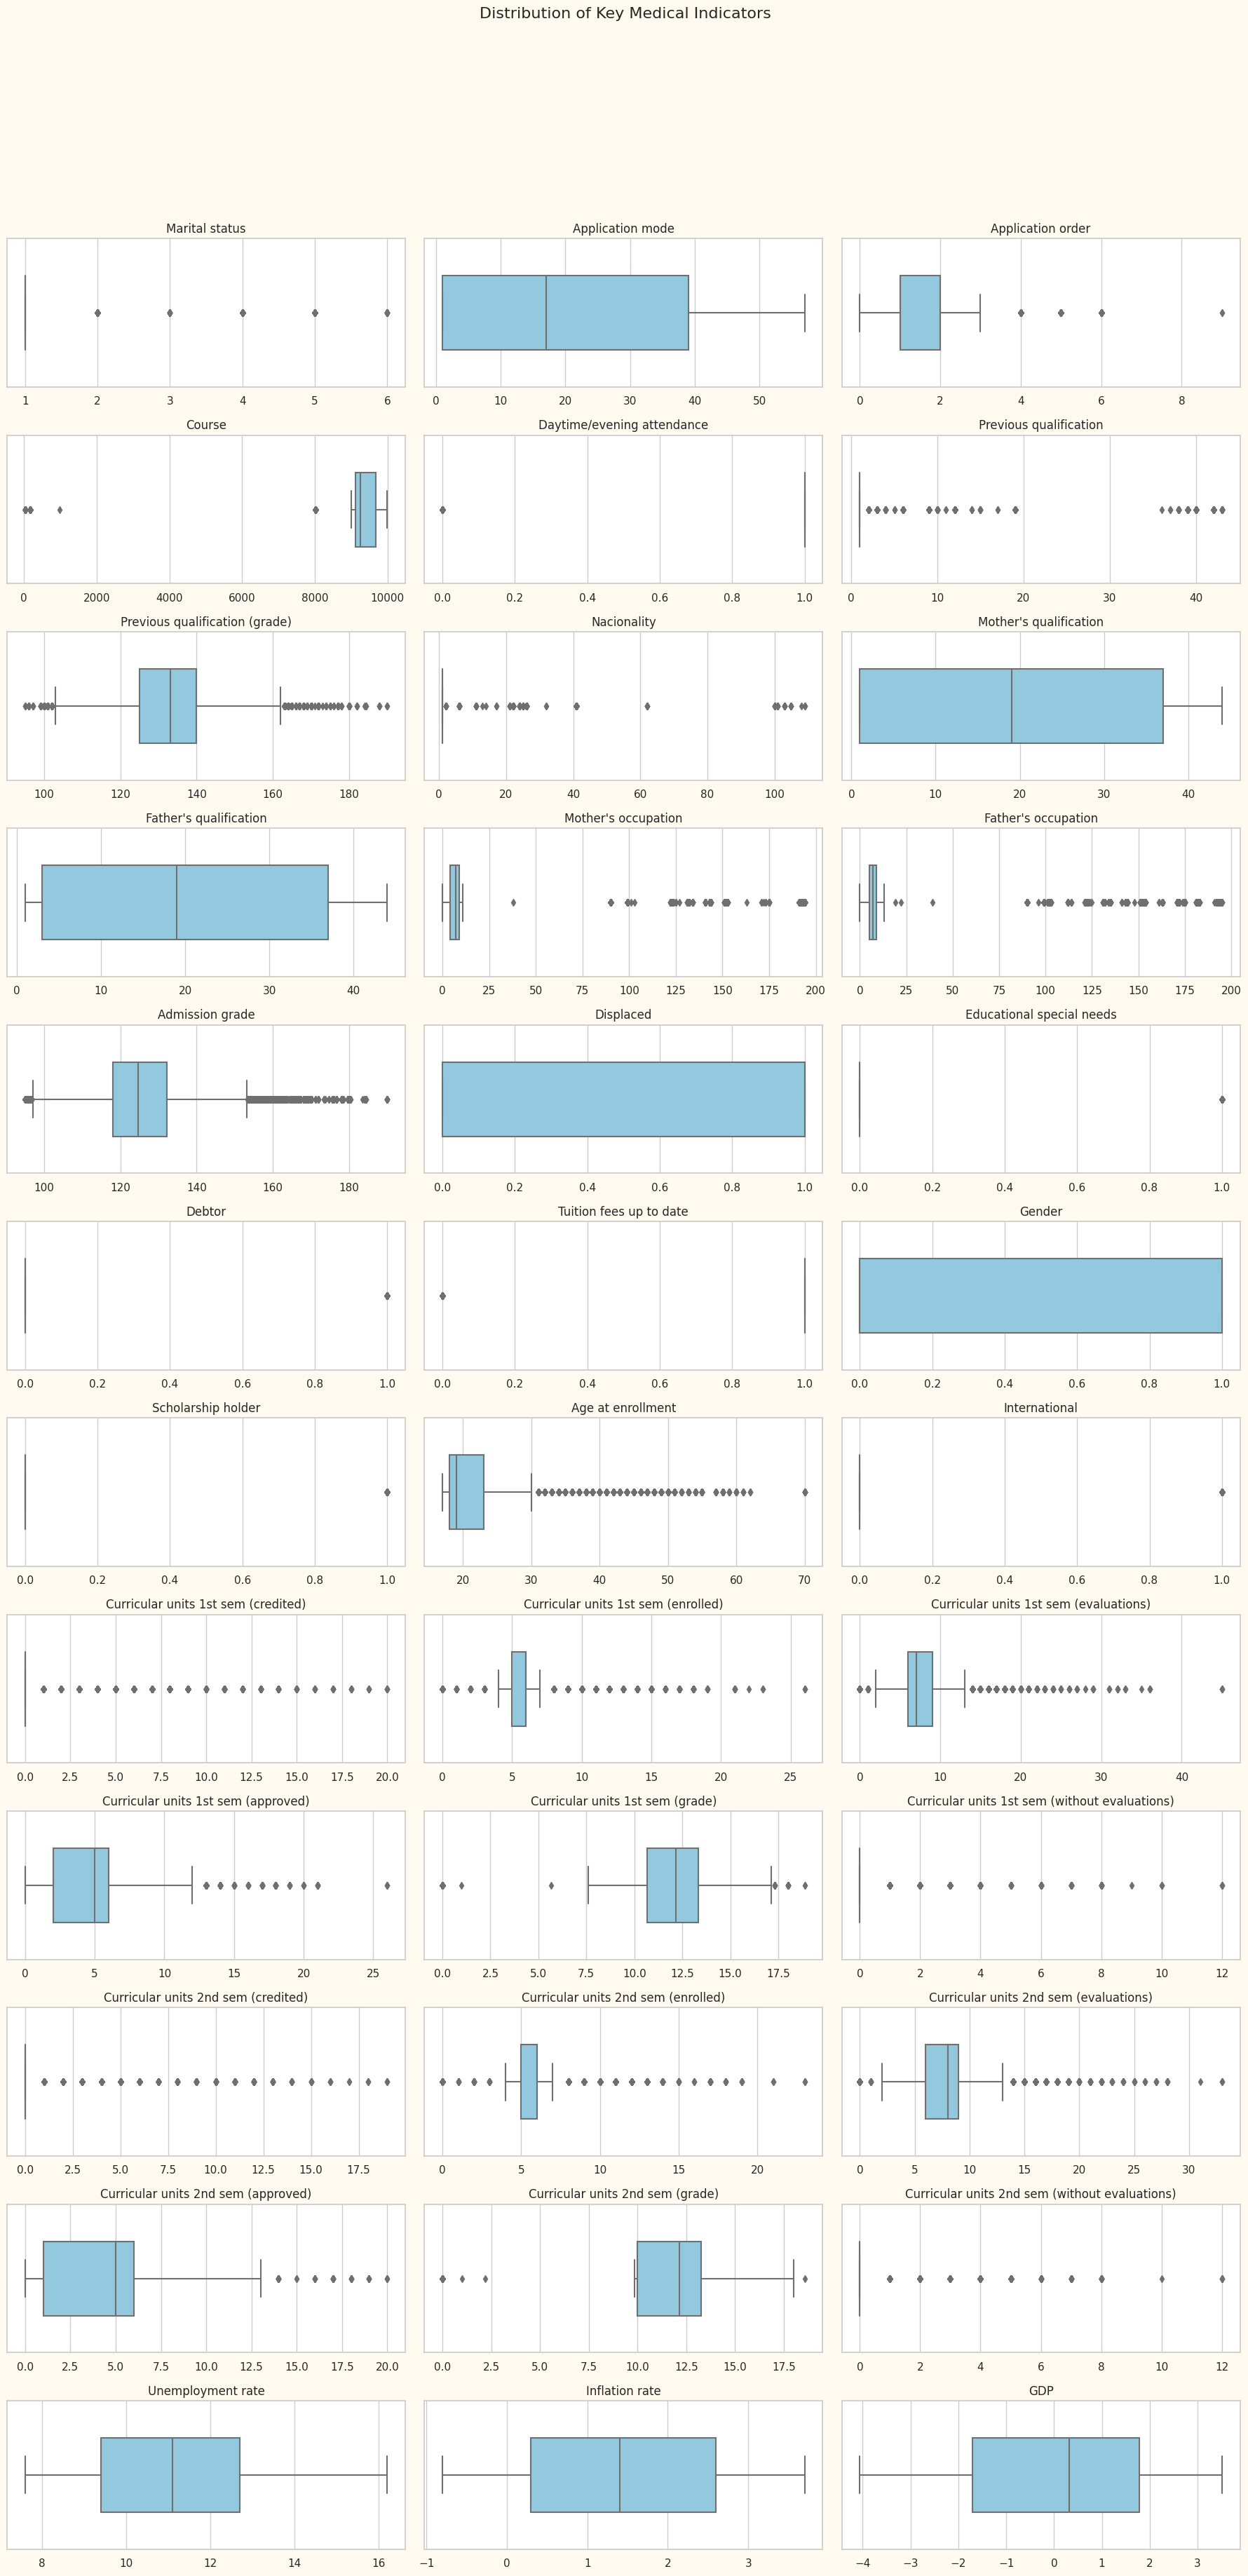

In [52]:
import math

# Number of numerical columns
num_columns = len(test_df.columns)

# Calculate the number of rows and columns needed for the subplots
num_cols = 3  # Fixed number of columns
num_rows = math.ceil(num_columns / num_cols)  # Calculate rows needed

plt.figure(figsize=(18, num_rows * 3))

sns.set_palette("husl")
sns.set(style="whitegrid")

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x=train_df[col], color='skyblue', width=0.5)
    plt.title(col)
    plt.xlabel("")

plt.suptitle("Distribution of Key Medical Indicators", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


<a id='3.2'></a>
## **2. Visualising Data Distribution and Skewness**

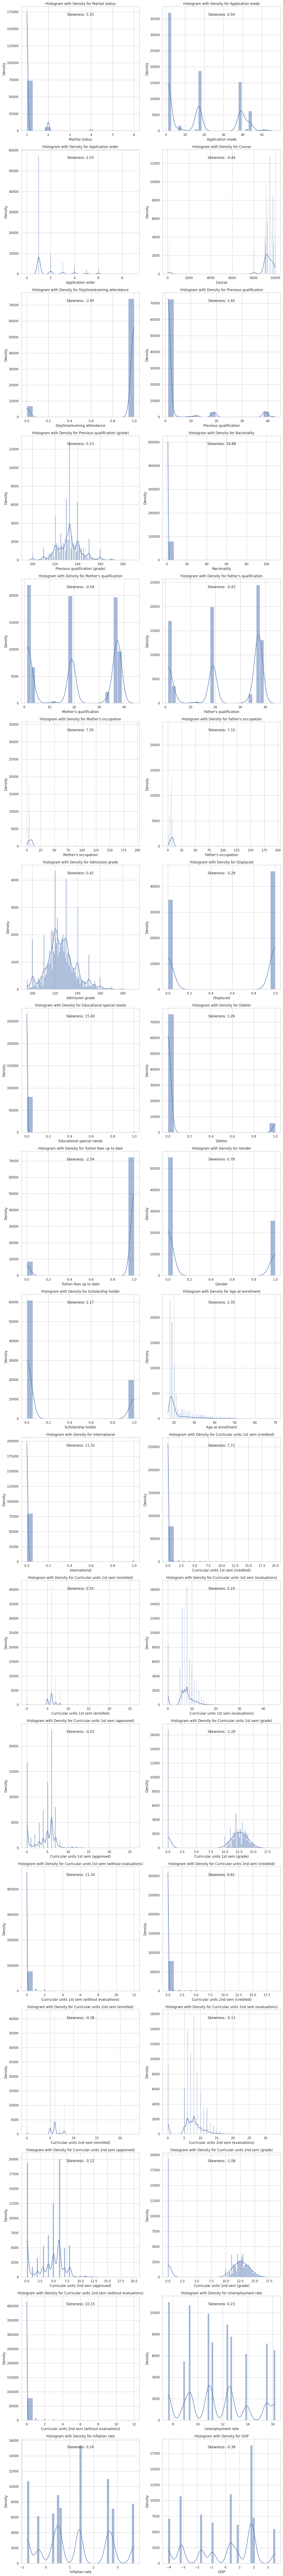

In [38]:
# Set the figure size and arrange plots horizontally in pairs
numerical_features = train_df.select_dtypes(include=['number']).columns
num_plots = len(numerical_features)
num_rows = (num_plots + 1) // 2  # Ensure enough rows to accommodate all features
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, 7*num_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through the selected columns and create histograms with density
for i, col in enumerate(numerical_features):
    sns.histplot(data=train_df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram with Density for {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

    # Calculate skewness
    skewness = skew(train_df[col].dropna())
    axes[i].text(0.5, 0.95, f'Skewness: {skewness:.2f}', horizontalalignment='center', verticalalignment='top', transform=axes[i].transAxes)

# Remove any empty subplots if the number of features is odd
if num_plots % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


- |Skewness| < 1: The distribution is approximately symmetric.
- |Skewness| > 1: The distribution is highly skewed.
- |Skewness| between 1 and 2: Moderately skewed distribution.

<a id='3.3'></a>
## **3. Visualising Class Distribution**

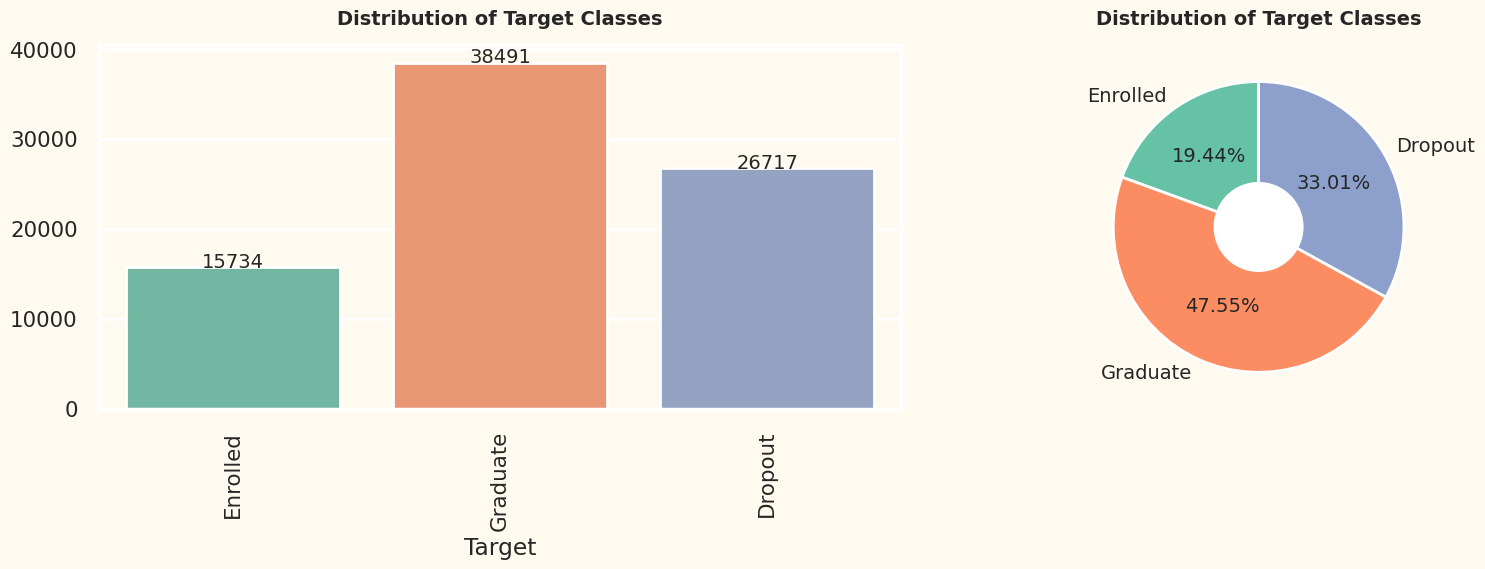

In [82]:

# Unique values of Target for multiclass
classes = ['Enrolled', 'Graduate', 'Dropout']

# Visualization to show distribution of Target classes in counts
plt.figure(figsize=(17, 6))

# Subplot 1: Bar plot of target class counts
plt.subplot(1, 2, 1)
Target_counts = train_df["Target"].value_counts().reindex(classes)
sns.barplot(x=Target_counts.index, y=Target_counts.values, palette='Set2')
plt.title("Distribution of Target Classes", fontweight="black", size=14, pad=15)
for i, v in enumerate(Target_counts.values):
    plt.text(i, v, v, ha="center", fontsize=14)
plt.xticks(rotation=90)

# Subplot 2: Pie chart of target class distribution
plt.subplot(1, 2, 2)
colors = sns.color_palette('Set2', len(classes))
plt.pie(Target_counts, labels=classes, autopct="%.2f%%", textprops={"size": 14},
        colors=colors, startangle=90)
center_circle = plt.Circle((0, 0), 0.3, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.title("Distribution of Target Classes", fontweight="black", size=14, pad=15)

plt.tight_layout()
plt.show()


# 4 | Preprocessing



<a id='4.1'></a>
## **1. Featutre Engineering**

In [39]:
numerical_columns = test_df.columns

In [40]:
def generate_features(df):
    # Create new features
    df['units failed 1'] = df['Curricular units 1st sem (enrolled)'] - df['Curricular units 1st sem (approved)']
    df['mean'] = df[numerical_columns].mean(axis=1).round(2)

    quartiles = df[numerical_columns].quantile([0.25, 0.5, 0.75], axis=1)
    df['second_quartile'] = quartiles.loc[0.5]
    df['third_quartile'] = quartiles.loc[0.75]

    #original_cols = list(X.columns)
    df['Inflation_GDP_ratio'] = df['Inflation rate'] / df['GDP']
    df['Unemployment_GDP_ratio'] = df['Unemployment rate'] / df['GDP']
    df['GDP_inflation_interaction'] = df['GDP'] * df['Inflation rate']
    return df

In [41]:
generate_features(train_df)

Marital status  Application mode  Application order  Course  \
0                  1                 1                  1    9238   
1                  1                17                  1    9238   
2                  1                17                  2    9254   
3                  1                 1                  3    9500   
4                  1                 1                  2    9500   
...              ...               ...                ...     ...   
4419               1                 1                  6    9773   
4420               1                 1                  2    9773   
4421               1                 1                  1    9500   
4422               1                 1                  1    9147   
4423               1                10                  1    9773   

      Daytime/evening attendance  Previous qualification  \
0                              1                       1   
1                              1                       1   
2                              1                       1   
3                              1                       1   
4                              1                       1   
...                          ...                     ...   
4419                           1                       1   
4420                           1                       1   
4421                           1                       1   
4422                           1                       1   
4423                           1                       1   

      Previous qualification (grade)  Nacionality  Mother's qualification  \
0                              126.0            1                       1   
1                              125.0            1                      19   
2                              137.0            1                       3   
3                              131.0            1                      19   
4                              132.0            1                      19   
...                              ...          ...                     ...   
4419                           125.0            1                       1   
4420                           120.0          105                       1   
4421                           154.0            1                      37   
4422                           180.0            1                      37   
4423                           152.0           22                      38   

      Father's qualification  Mother's occupation  Father's occupation  \
0                         19                    5                    5   
1                         19                    9                    9   
2                         19                    2                    3   
3                          3                    3                    2   
4                         37                    4                    9   
...                      ...                  ...                  ...   
4419                       1                    5                    4   
4420                       1                    9                    9   
4421                      37                    9                    9   
4422                      37                    7                    4   
4423                      37                    5                    9   

      Admission grade  Displaced  Educational special needs  Debtor  \
0               122.6          0                          0       0   
1               119.8          1                          0       0   
2               144.7          0                          0       0   
3               126.1          1                          0       0   
4               120.1          1                          0       0   
...               ...        ...                        ...     ...   
4419            122.2          0                          0       0   
4420            119.0          1                          0       1   
442

In [42]:
generate_features(test_df)

Marital status  Application mode  Application order  Course  \
0                   1                 1                  1    9500   
1                   1                 1                  1    9238   
2                   1                 1                  1    9238   
3                   1                44                  1    9147   
4                   1                39                  1    9670   
...               ...               ...                ...     ...   
51007               1                 1                  2     171   
51008               2                39                  1    9119   
51009               1                 1                  1     171   
51010               1                 1                  3    9773   
51011               1                 1                  1     171   

       Daytime/evening attendance  Previous qualification  \
0                               1                       1   
1                               1                       1   
2                               1                       1   
3                               1                      39   
4                               1                       1   
...                           ...                     ...   
51007                           1                       1   
51008                           1                      19   
51009                           1                       1   
51010                           1                       1   
51011                           1                       1   

       Previous qualification (grade)  Nacionality  Mother's qualification  \
0                               141.0            1                       3   
1                               128.0            1                       1   
2                               118.0            1                       1   
3                               130.0            1                       1   
4                               110.0            1                       1   
...                               ...          ...                     ...   
51007                           128.0            1                      38   
51008                           133.1            1                      19   
51009                           127.0            1                       1   
51010                           132.0            1                      19   
51011                           129.0            1                      37   

       Father's qualification  Mother's occupation  Father's occupation  \
0                           1                    2                    3   
1                          19                    4                    5   
2                          19                    4                    9   
3                          19                    3                    3   
4                          37                    5                    5   
...                       ...                  ...                  ...   
51007                      37                    7                   10   
51008                      37                    9                    9   
51009                       1                    4                   10   
51010                      19                    5                    5   
51011                      38                    9                    9   

       Admission grade  Displaced  Educational special needs  Debtor  \
0                152.1          0                          0       0   
1                116.5          0                          0       0   
2                114.2          0                          0       0   
3                130.0          0                          0       0   
4                106.0          1                          0       0   
...                ...        ...                        ...     ...   
51007            124.7          1                          0       0   
51008            14

In [189]:
test_df.shape

(51012, 43)

<a id='4.2'></a>
## **2. Target feature Encoding**

In [43]:
label_encoder = LabelEncoder()

In [44]:
train_df['Target'] = label_encoder.fit_transform(train_df['Target'])

In [45]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}


<a id='4.3'></a>
## **3. checking Highly Correlated Features**

<Axes: title={'center': 'Correlation Plot'}>

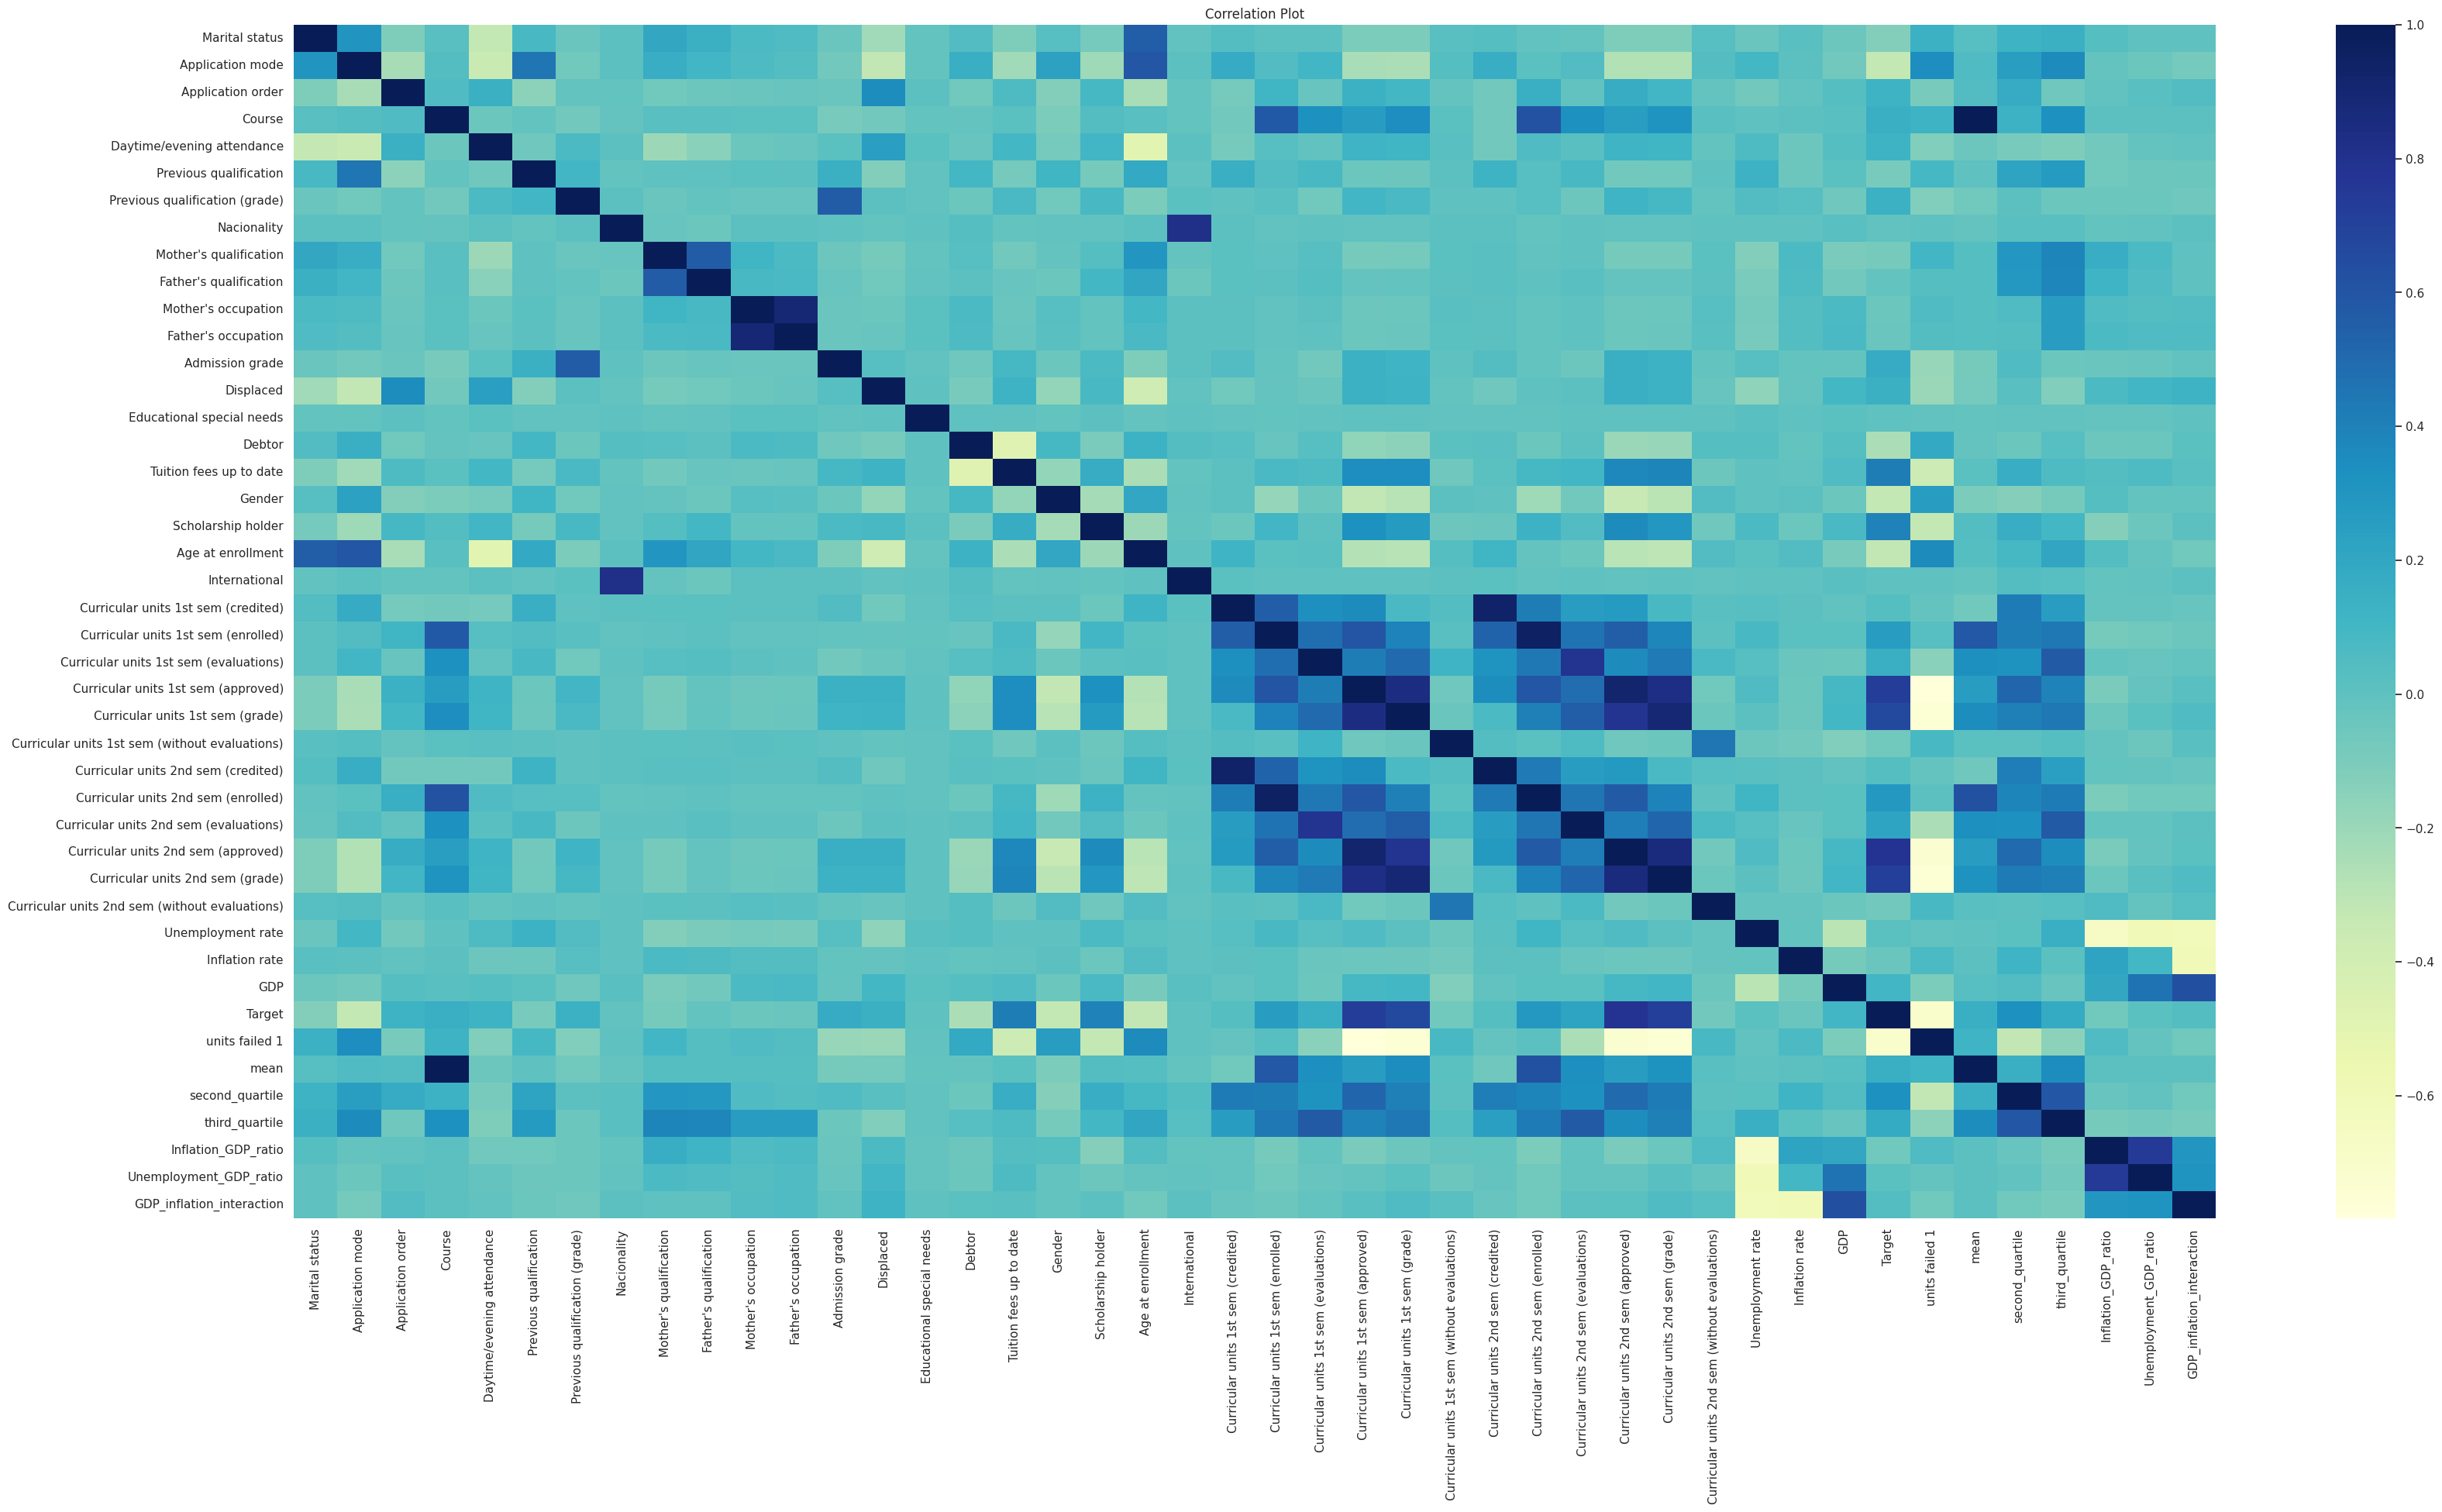

In [ ]:
plt.figure(figsize=(40,20))
plt.title("Correlation Plot")
sns.heatmap(train_df.corr(),cmap='YlGnBu')

In [46]:
# Calculate the correlation matrix
correlation_matrix = train_df.corr()

# Create a mask to identify the features with a correlation coefficient greater than or equal to 0.75
high_correlation_mask = correlation_matrix >= 0.75

# Identify and list the highly correlated features
highly_correlated_features = []

for feature in high_correlation_mask.columns:
    correlated_with = high_correlation_mask.index[high_correlation_mask[feature]].tolist()
    for correlated_feature in correlated_with:
        if feature != correlated_feature and (correlated_feature, feature) not in highly_correlated_features:
            highly_correlated_features.append((feature, correlated_feature))

# Print the highly correlated features
print("Highly correlated features:")
for feature1, feature2 in highly_correlated_features:
    print(f"{feature1} and {feature2}")


Highly correlated features:
Course and mean
Nacionality and International
Mother's occupation and Father's occupation
Curricular units 1st sem (credited) and Curricular units 2nd sem (credited)
Curricular units 1st sem (enrolled) and Curricular units 2nd sem (enrolled)
Curricular units 1st sem (evaluations) and Curricular units 2nd sem (evaluations)
Curricular units 1st sem (approved) and Curricular units 1st sem (grade)
Curricular units 1st sem (approved) and Curricular units 2nd sem (approved)
Curricular units 1st sem (approved) and Curricular units 2nd sem (grade)
Curricular units 1st sem (grade) and Curricular units 2nd sem (approved)
Curricular units 1st sem (grade) and Curricular units 2nd sem (grade)
Curricular units 2nd sem (approved) and Curricular units 2nd sem (grade)
Curricular units 2nd sem (approved) and Target


In [46]:
# droping columns which are highly correlated
cols = ['Nacionality']
train_df.drop(columns=cols, inplace=True)
test_df.drop(columns=cols, inplace=True)

In [47]:
train_df

Marital status  Application mode  Application order  Course  \
0                  1                 1                  1    9238   
1                  1                17                  1    9238   
2                  1                17                  2    9254   
3                  1                 1                  3    9500   
4                  1                 1                  2    9500   
...              ...               ...                ...     ...   
4419               1                 1                  6    9773   
4420               1                 1                  2    9773   
4421               1                 1                  1    9500   
4422               1                 1                  1    9147   
4423               1                10                  1    9773   

      Daytime/evening attendance  Previous qualification  \
0                              1                       1   
1                              1                       1   
2                              1                       1   
3                              1                       1   
4                              1                       1   
...                          ...                     ...   
4419                           1                       1   
4420                           1                       1   
4421                           1                       1   
4422                           1                       1   
4423                           1                       1   

      Previous qualification (grade)  Mother's qualification  \
0                              126.0                       1   
1                              125.0                      19   
2                              137.0                       3   
3                              131.0                      19   
4                              132.0                      19   
...                              ...                     ...   
4419                           125.0                       1   
4420                           120.0                       1   
4421                           154.0                      37   
4422                           180.0                      37   
4423                           152.0                      38   

      Father's qualification  Mother's occupation  Father's occupation  \
0                         19                    5                    5   
1                         19                    9                    9   
2                         19                    2                    3   
3                          3                    3                    2   
4                         37                    4                    9   
...                      ...                  ...                  ...   
4419                       1                    5                    4   
4420                       1                    9                    9   
4421                      37                    9                    9   
4422                      37                    7                    4   
4423                      37                    5                    9   

      Admission grade  Displaced  Educational special needs  Debtor  \
0               122.6          0                          0       0   
1               119.8          1                          0       0   
2               144.7          0                          0       0   
3               126.1          1                          0       0   
4               120.1          1                          0       0   
...               ...        ...                        ...     ...   
4419            122.2          0                          0       0   
4420            119.0          1                          0       1   
4421            149.5          1                          0       0   
4422            153.8          1                          0       0   
4423            1

<a id='4.4'></a>
## **4. Splitting the features in dependent and independent features**


In [48]:
x = train_df.drop(['Target'], axis=1)
y = train_df['Target']

In [49]:
from sklearn.utils.class_weight import compute_class_weight
# Convert y to a NumPy array if it's not already one
arr = np.array(y)

# Calculate unique classes in y
unique_classes = np.unique(arr)

# Convert unique_classes to a list to ensure hashability
unique_classes_list = list(unique_classes)

# Calculate class weights based on the training data
class_weights = compute_class_weight('balanced',
                                     classes=unique_classes,
                                     y=y)

# Create a dictionary of class weights
class_weights_dict = dict(zip(unique_classes_list, class_weights))
print(class_weights_dict)

{0: 1.0098688725031504, 1: 1.714800220329647, 2: 0.7009603976687191}


In [49]:
class_weights_dict = {0: 1.0098688725031504, 1: 1.714800220329647, 2: 0.7009603976687191}

<a id='4.5'></a>
## **5. Checking Feature Importance**


In [50]:
discrete_features = x.dtypes == int

def mi_score_maker(x,y,discrete_features):
    scores = mutual_info_regression(x,y,discrete_features=discrete_features)
    df = pd.DataFrame({
        'Features':x.columns,
        'Scores':scores
    })
    df = df.sort_values(['Scores'],ascending=False).reset_index(drop=True)
    return df

In [51]:
mi_scores = mi_score_maker(x,y.astype('float64'),discrete_features)

mi_scores

Features    Scores
0              Curricular units 2nd sem (approved)  0.469114
1                 Curricular units 2nd sem (grade)  0.405855
2              Curricular units 1st sem (approved)  0.401168
3                 Curricular units 1st sem (grade)  0.351023
4                                   units failed 1  0.341320
5           Curricular units 2nd sem (evaluations)  0.196509
6           Curricular units 1st sem (evaluations)  0.184353
7                                   third_quartile  0.151123
8                                  second_quartile  0.131337
9                                           Course  0.113940
10                         Tuition fees up to date  0.111214
11                                 Admission grade  0.106029
12                               Age at enrollment  0.099266
13                                            mean  0.094375
14                              Scholarship holder  0.091807
15                                Application mode  0.086363
16                  Previous qualification (grade)  0.085060
17             Curricular units 2nd sem (enrolled)  0.082634
18             Curricular units 1st sem (enrolled)  0.077473
19                                          Gender  0.059723
20                          Previous qualification  0.042713
21                                          Debtor  0.042277
22                             Mother's occupation  0.032343
23                          Mother's qualification  0.031695
24                          Father's qualification  0.028370
25                             Father's occupation  0.026494
26                                  Marital status  0.020291
27                      Daytime/evening attendance  0.018495
28                               Application order  0.017029
29                                       Displaced  0.015941
30  Curricular units 2nd sem (without evaluations)  0.014867
31                       GDP_inflation_interaction  0.014259
32                                             GDP  0.013822
33  Curricular units 1st sem (without evaluations)  0.013142
34                          Unemployment_GDP_ratio  0.012708
35                             Inflation_GDP_ratio  0.012472
36                               Unemployment rate  0.012118
37             Curricular units 1st sem (credited)  0.010833
38                                   International  0.010269
39                       Educational special needs  0.010036
40             Curricular units 2nd sem (credited)  0.009714
41                                  Inflation rate  0.007848

In [52]:
# Filter features with scores less than 0.001285
low_score_features = mi_scores[mi_scores['Scores'] < 0.01]

# Extract the feature names
low_score_feature_names = low_score_features['Features'].tolist()

# Print the list of low score feature names
low_score_feature_names

['Curricular units 2nd sem (credited)', 'Inflation rate']

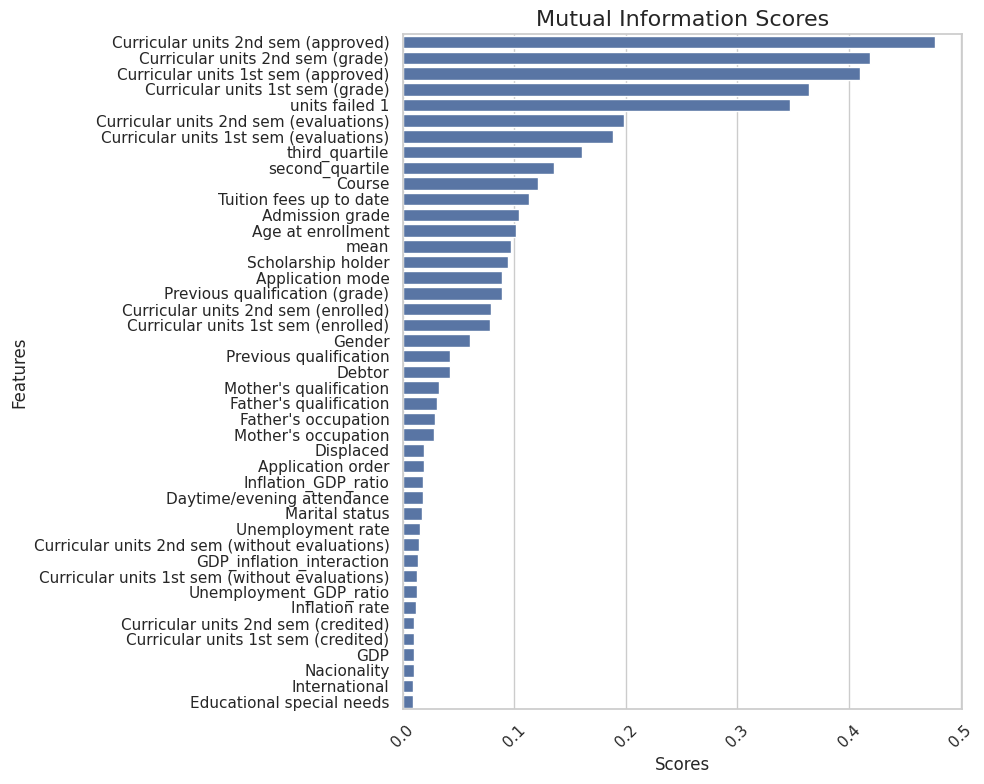

In [ ]:
plt.figure(figsize=(10, 8))

# Create the barplot
sns.barplot(x='Scores', y='Features', data=mi_scores)

# Add a title
plt.title("Mutual Information Scores", fontsize=16)

# Rotate the y-axis labels (if needed)
plt.yticks(rotation=0)

# Rotate the x-axis labels (if needed)
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlap
plt.show()

In [53]:
x.drop(low_score_feature_names,axis = 1,inplace = True)
test_df.drop(low_score_feature_names,axis = 1,inplace = True)


## **6.Feature Scaling**


In [54]:
scaler = StandardScaler()

In [55]:
print(x.shape)
print(test_df.shape)

(80942, 40)
(51012, 40)


In [56]:
x_scaled = scaler.fit_transform(x)

In [57]:
test_df_scaled = scaler.transform(test_df)

<a id='4.7'></a>
## **7.Implementing PCA**

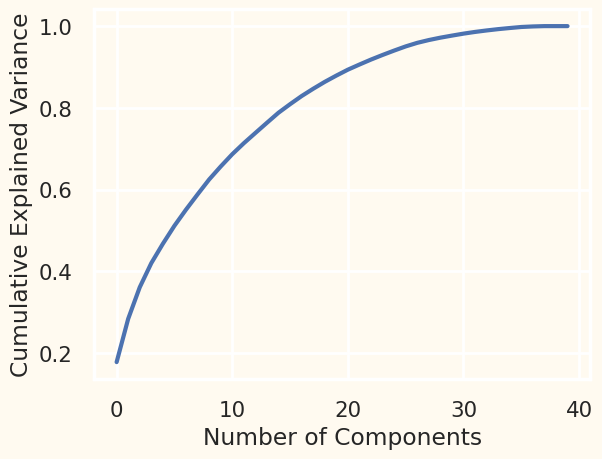

In [58]:
pca = PCA()
pca.fit(x_scaled)  # X_train is your training data
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


In [59]:
## PCA- Transformation
pca=PCA(n_components=35)
pca

PCA(n_components=35)

In [60]:
#Scaled Data
x_scaled=pca.fit_transform(x_scaled)

In [61]:
test_df_scaled = pca.transform(test_df_scaled)

In [75]:
test_df_scaled

array([[-4.08184030e+00, -3.61283988e-01, -9.96826932e-01, ...,
         6.83365060e-01,  4.13564702e-02,  7.41665213e-02],
       [ 7.21955536e-01, -1.81575605e+00,  1.13632556e-01, ...,
         2.40122400e-01, -1.34351232e-02,  8.72509290e-02],
       [ 1.52049255e+00, -3.62337231e-01, -3.08839728e+00, ...,
        -5.58958505e-01,  7.46252262e-02, -7.69825914e-02],
       ...,
       [-8.19765904e+00, -2.30548308e+00, -4.18032323e+00, ...,
         8.61040681e-02,  2.30993650e-01,  2.62978072e-02],
       [ 2.31575263e-01, -5.41743422e-01,  2.65115486e+00, ...,
         2.57607501e-01, -6.25972403e-02, -1.72670150e-01],
       [-7.90465965e+00, -2.85621446e+00,  2.14896975e+00, ...,
        -3.61478056e-02, -3.92678331e-02,  7.27999381e-03]])


## **8 .Dividing in train-test-split**


#### **Split the Data into training and testing for unscaled**

In [62]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#### **Split the Data into training and testing for scaled**

In [63]:
x_train_scaled, x_test_scaled, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)



# 5 | Baseline Model Building




In [64]:
Training_Accuracy = []
Testing_Accuracy = []

#For scaled data
def model_prediction(model, x, y, n_splits, random_state):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    training_score = []
    testing_score = []
    precission = []
    recall = []
    f1_score_ = []


    x = pd.DataFrame(x)  # Convert x to DataFrame

    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(x_train, y_train)
        x_train_pred = model.predict(x_train)
        x_test_pred = model.predict(x_test)

        a = accuracy_score(y_train, x_train_pred) * 100
        b = accuracy_score(y_test, x_test_pred) * 100
        c = precision_score(y_test, x_test_pred, average='weighted')
        d = recall_score(y_test, x_test_pred, average='weighted')
        e = f1_score(y_test, x_test_pred, average='weighted')

        training_score.append(a)
        testing_score.append(b)
        precission.append(c)
        recall.append(d)
        f1_score_.append(e)

    print("\n------------------------------------------------------------------------")
    print(f"Mean Accuracy_Score of {model} model on Training Data is:", np.mean(training_score))
    print(f"Mean Accuracy_Score of {model} model on Testing Data is:", np.mean(testing_score))
    print(f"Mean Precision Score of {model} model is:", np.mean(precission))
    print(f"Mean Recall Score of {model} model is:", np.mean(recall))
    print(f"Mean f1 Score of {model} model is:", np.mean(f1_score_))

    # Classification report and confusion matrix
    print("\n------------------------------------------------------------------------")
    print(f"Classification Report of {model} model is:")
    print(classification_report(y_test, x_test_pred))

    print("\n------------------------------------------------------------------------")
    print(f"Confusion Matrix of {model} model is:")
    cm = confusion_matrix(y_test, x_test_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="g", cmap="summer")
    plt.show()

    Training_Accuracy.append(np.mean(training_score))
    Testing_Accuracy.append(np.mean(testing_score))

#### **models trained on scaled data**



## **1. SGD Classifier**

In [ ]:
sgd_model = SGDClassifier()


------------------------------------------------------------------------
Mean Accuracy_Score of SGDClassifier() model on Training Data is: 80.29254435549458
Mean Accuracy_Score of SGDClassifier() model on Testing Data is: 80.22426245802724
Mean Precision Score of SGDClassifier() model is: 0.7949842984312747
Mean Recall Score of SGDClassifier() model is: 0.8022426245802723
Mean f1 Score of SGDClassifier() model is: 0.7938672586430903

------------------------------------------------------------------------
Classification Report of SGDClassifier() model is:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      5059
           1       0.62      0.50      0.55      2988
           2       0.82      0.93      0.87      7256

    accuracy                           0.81     15303
   macro avg       0.77      0.75      0.76     15303
weighted avg       0.80      0.81      0.80     15303


-------------------------------------------------------

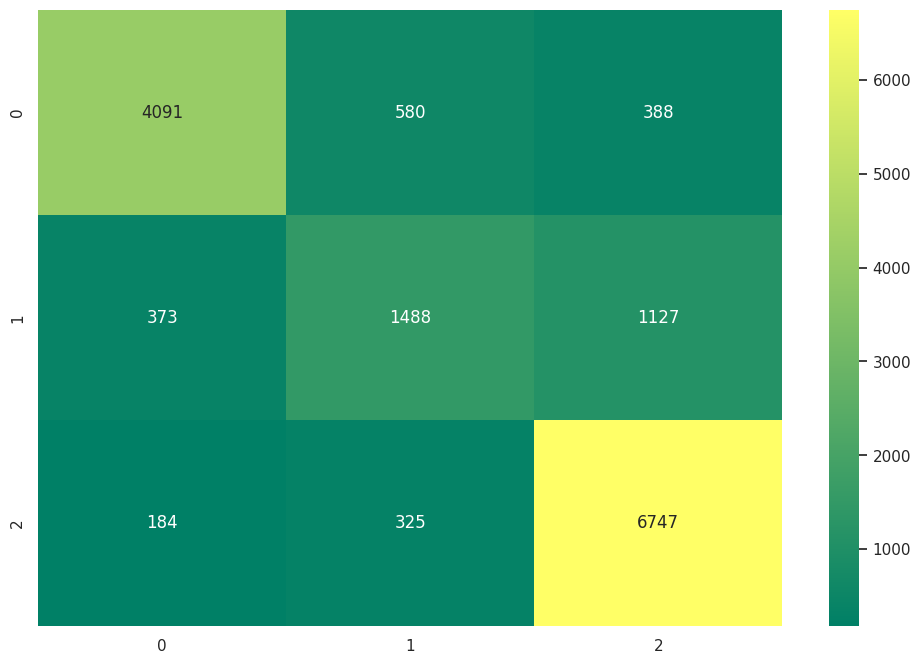

In [ ]:
model_prediction(sgd_model, x_scaled, y, n_splits=5, random_state=42)


## **2. Logisitc Regression**

In [ ]:
LogisticRegression_model = LogisticRegression()


------------------------------------------------------------------------
Mean Accuracy_Score of LogisticRegression() model on Training Data is: 81.60204146919234
Mean Accuracy_Score of LogisticRegression() model on Testing Data is: 81.53898473350944
Mean Precision Score of LogisticRegression() model is: 0.8128513428507681
Mean Recall Score of LogisticRegression() model is: 0.8153898473350945
Mean f1 Score of LogisticRegression() model is: 0.8121581074691211

------------------------------------------------------------------------
Classification Report of LogisticRegression() model is:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      5059
           1       0.62      0.56      0.59      2988
           2       0.83      0.92      0.88      7256

    accuracy                           0.82     15303
   macro avg       0.78      0.77      0.77     15303
weighted avg       0.81      0.82      0.81     15303


-------------------------

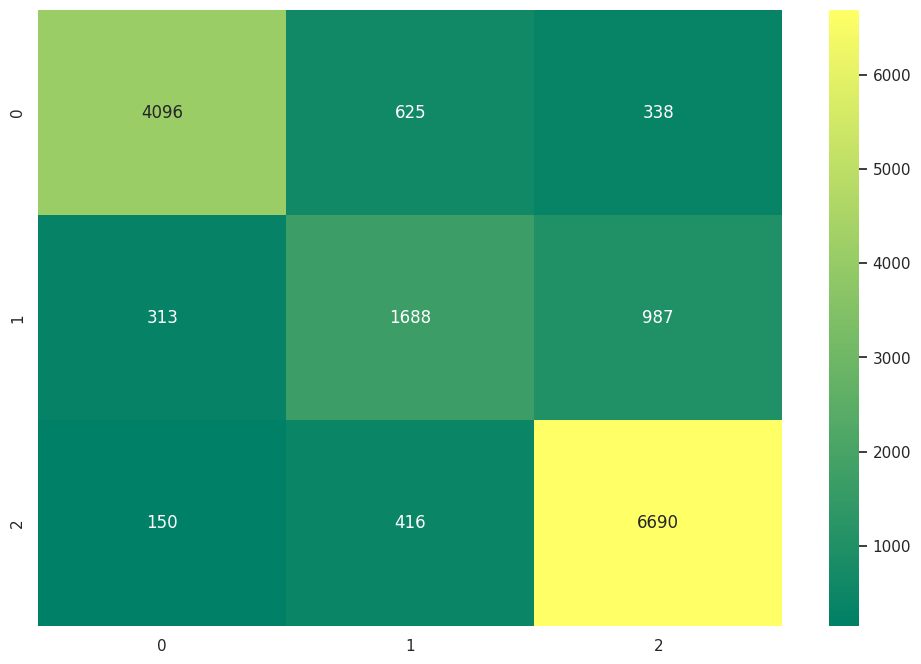

In [ ]:
model_prediction(LogisticRegression_model, x_scaled, y, n_splits=5, random_state=42)


## **3. K Nearest Neighbor**

In [ ]:
KNN_Model = KNeighborsClassifier()


------------------------------------------------------------------------
Mean Accuracy_Score of KNeighborsClassifier() model on Training Data is: 83.95181514817855
Mean Accuracy_Score of KNeighborsClassifier() model on Testing Data is: 77.81960095220987
Mean Precision Score of KNeighborsClassifier() model is: 0.7728156865809777
Mean Recall Score of KNeighborsClassifier() model is: 0.7781960095220986
Mean f1 Score of KNeighborsClassifier() model is: 0.7745422114452304

------------------------------------------------------------------------
Classification Report of KNeighborsClassifier() model is:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      5059
           1       0.54      0.50      0.52      2988
           2       0.82      0.88      0.85      7256

    accuracy                           0.78     15303
   macro avg       0.73      0.72      0.73     15303
weighted avg       0.77      0.78      0.77     15303


-------------

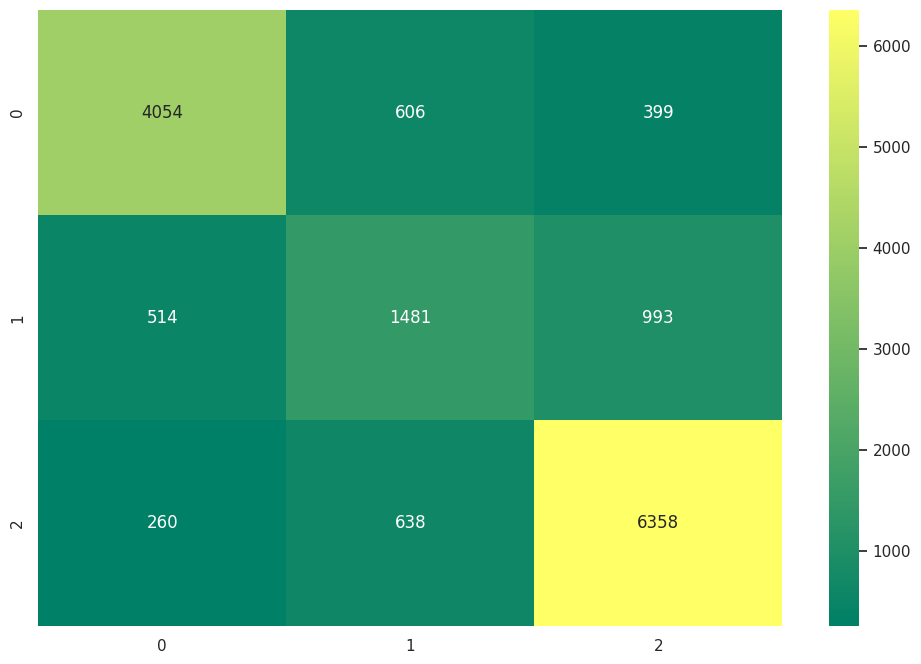

In [ ]:
model_prediction(KNN_Model, x_scaled, y, n_splits=5, random_state=42)


## **4. Naive Bayes**

In [ ]:
NB_model = GaussianNB()


------------------------------------------------------------------------
Mean Accuracy_Score of GaussianNB() model on Training Data is: 73.06222031812368
Mean Accuracy_Score of GaussianNB() model on Testing Data is: 73.00244095238887
Mean Precision Score of GaussianNB() model is: 0.7147421298149703
Mean Recall Score of GaussianNB() model is: 0.7300244095238886
Mean f1 Score of GaussianNB() model is: 0.7171830368437278

------------------------------------------------------------------------
Classification Report of GaussianNB() model is:
              precision    recall  f1-score   support

           0       0.78      0.77      0.77      5059
           1       0.53      0.35      0.42      2988
           2       0.76      0.86      0.80      7256

    accuracy                           0.73     15303
   macro avg       0.69      0.66      0.67     15303
weighted avg       0.72      0.73      0.72     15303


------------------------------------------------------------------------


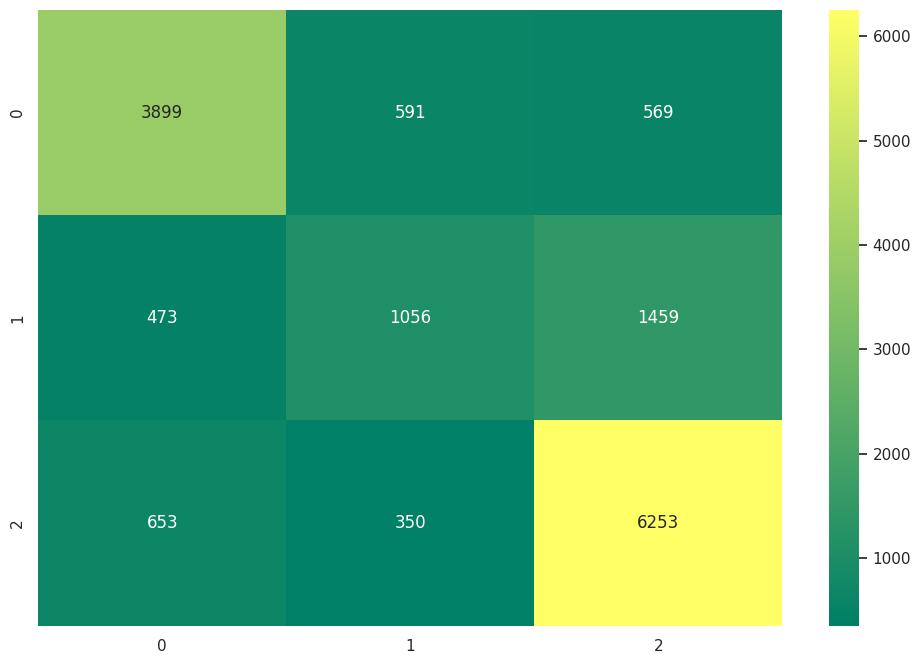

In [ ]:
model_prediction(NB_model, x_scaled, y, n_splits=5, random_state=42)

#### **Model trained on unscaled data**



## **5. Decision Tree**

In [ ]:
DecisionTreeClassifier_model = DecisionTreeClassifier()


------------------------------------------------------------------------
Mean Accuracy_Score of DecisionTreeClassifier() model on Training Data is: 100.0
Mean Accuracy_Score of DecisionTreeClassifier() model on Testing Data is: 74.1564077015604
Mean Precision Score of DecisionTreeClassifier() model is: 0.7442213280132097
Mean Recall Score of DecisionTreeClassifier() model is: 0.7415640770156038
Mean f1 Score of DecisionTreeClassifier() model is: 0.7428263935466963

------------------------------------------------------------------------
Classification Report of DecisionTreeClassifier() model is:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      5059
           1       0.47      0.49      0.48      2988
           2       0.82      0.81      0.81      7256

    accuracy                           0.74     15303
   macro avg       0.69      0.70      0.70     15303
weighted avg       0.74      0.74      0.74     15303


--------------

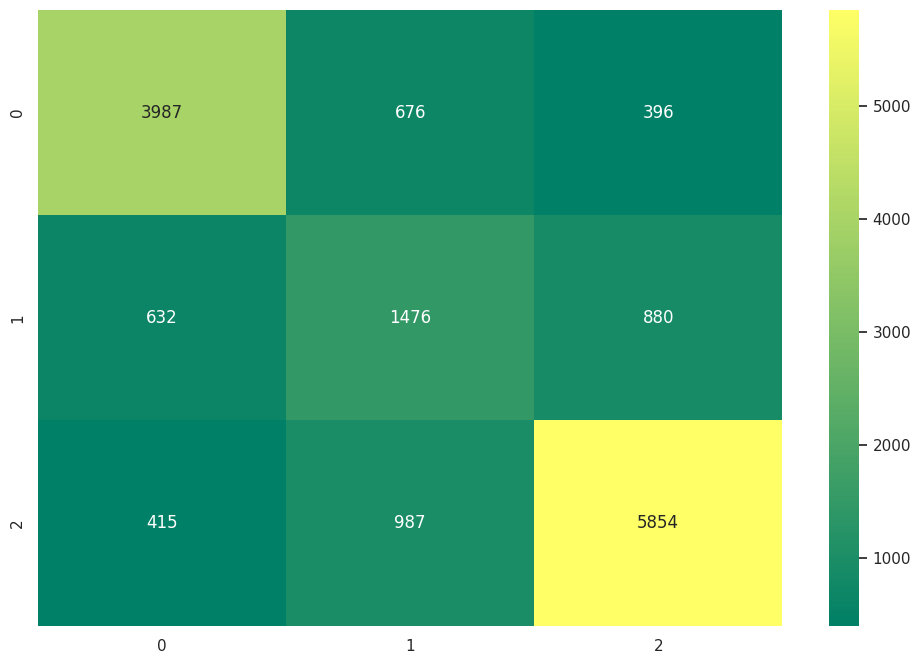

In [ ]:
model_prediction(DecisionTreeClassifier_model, x, y, n_splits=5, random_state=42)

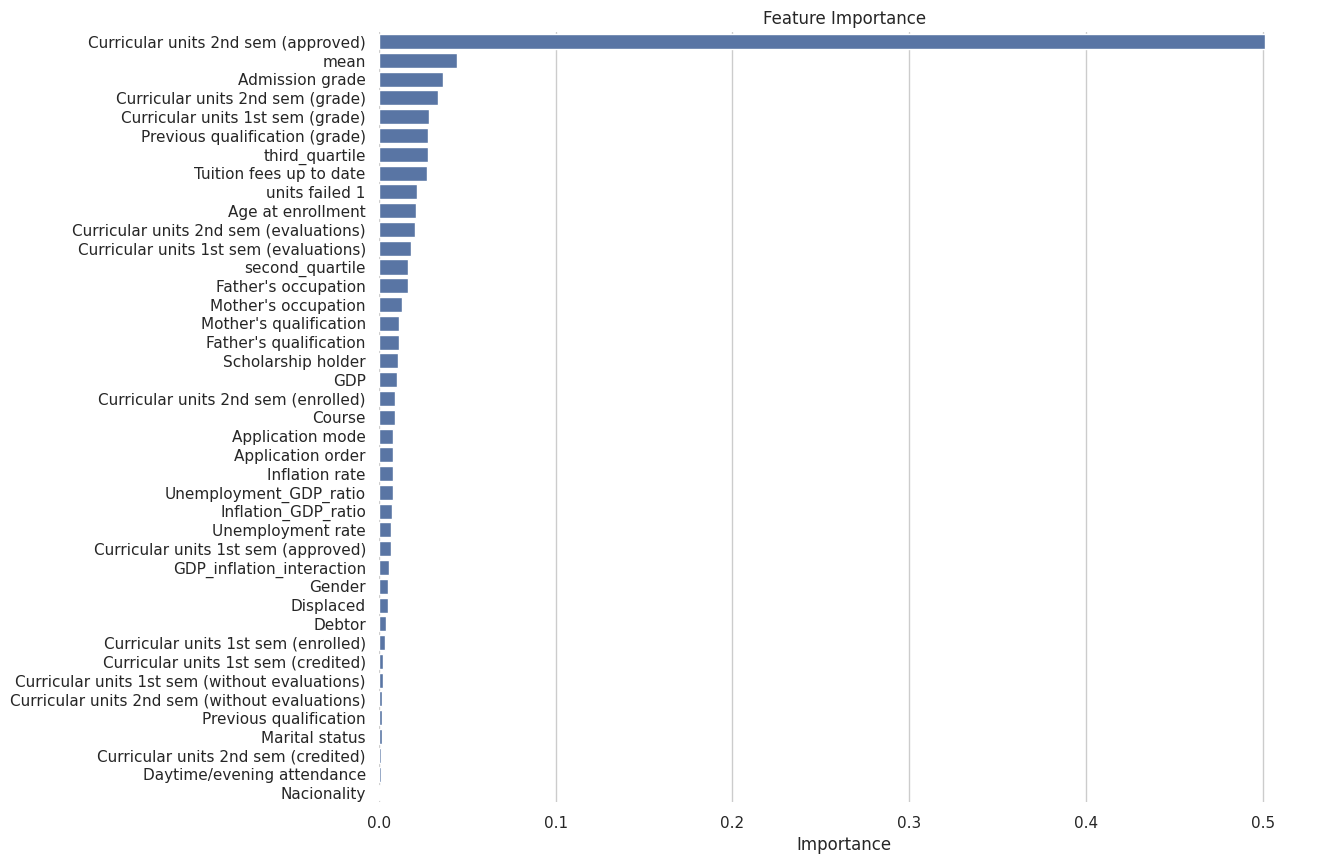

In [ ]:
# feature importances
feature_importance = DecisionTreeClassifier_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()


## **6. Extra Tree Classifier**

In [ ]:
ETCLF_model = ExtraTreesClassifier()


------------------------------------------------------------------------
Mean Accuracy_Score of ExtraTreesClassifier() model on Training Data is: 100.0
Mean Accuracy_Score of ExtraTreesClassifier() model on Testing Data is: 82.15974909203834
Mean Precision Score of ExtraTreesClassifier() model is: 0.820126746385115
Mean Recall Score of ExtraTreesClassifier() model is: 0.8215974909203834
Mean f1 Score of ExtraTreesClassifier() model is: 0.8191655935535381

------------------------------------------------------------------------
Classification Report of ExtraTreesClassifier() model is:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      5059
           1       0.63      0.59      0.61      2988
           2       0.84      0.92      0.88      7256

    accuracy                           0.82     15303
   macro avg       0.79      0.77      0.78     15303
weighted avg       0.82      0.82      0.82     15303


--------------------------

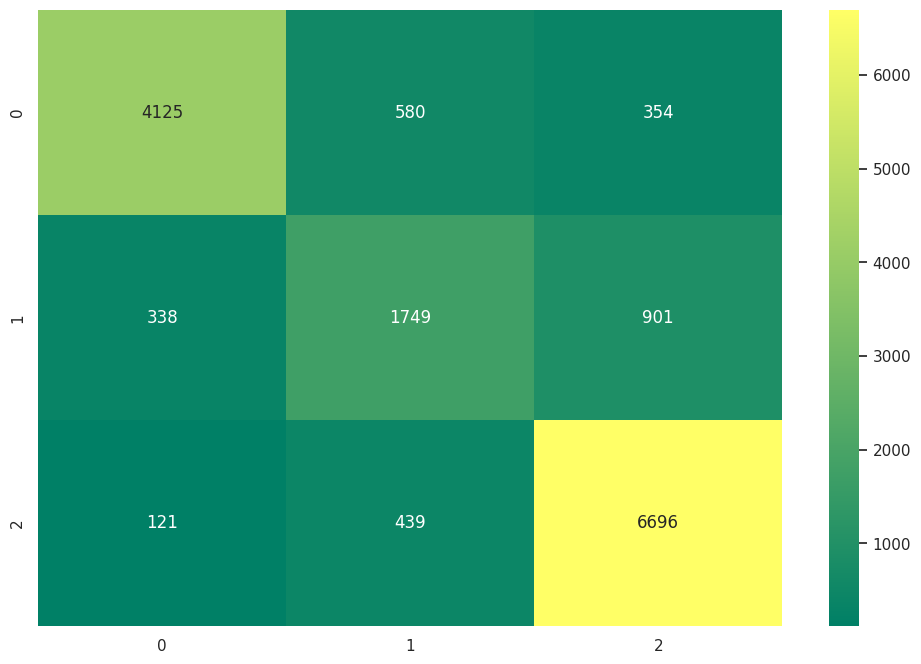

In [ ]:
model_prediction(ETCLF_model, x, y, n_splits=5, random_state=42)

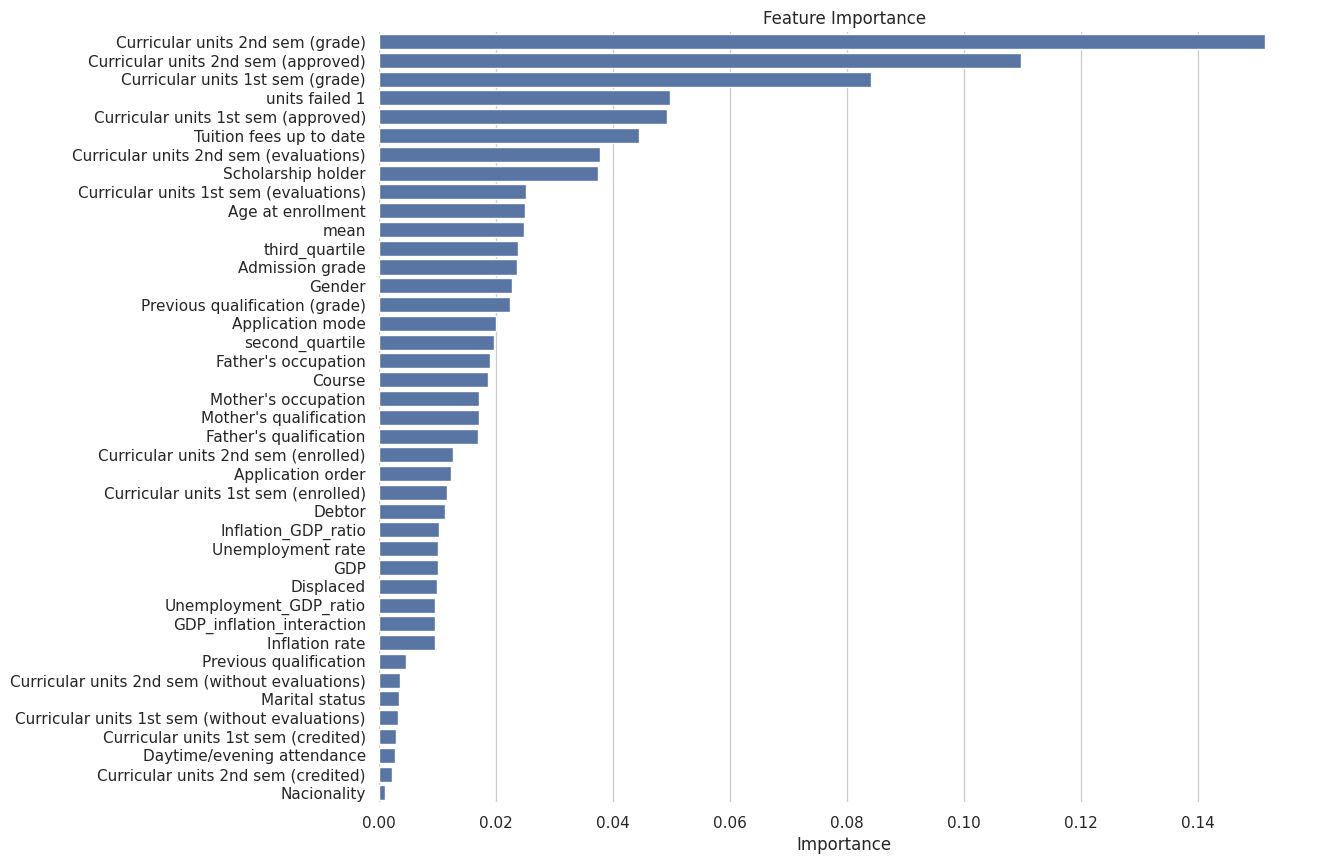

In [ ]:
# feature importances
feature_importance = ETCLF_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()


## **7. Random Forest**

In [ ]:
RF_model = RandomForestClassifier()


------------------------------------------------------------------------
Mean Accuracy_Score of RandomForestClassifier() model on Training Data is: 99.9986931094194
Mean Accuracy_Score of RandomForestClassifier() model on Testing Data is: 82.50607155224016
Mean Precision Score of RandomForestClassifier() model is: 0.8232252830930472
Mean Recall Score of RandomForestClassifier() model is: 0.8250607155224013
Mean f1 Score of RandomForestClassifier() model is: 0.8226463521366231

------------------------------------------------------------------------
Classification Report of RandomForestClassifier() model is:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      5059
           1       0.64      0.60      0.62      2988
           2       0.85      0.92      0.88      7256

    accuracy                           0.82     15303
   macro avg       0.80      0.78      0.79     15303
weighted avg       0.82      0.82      0.82     15303


--

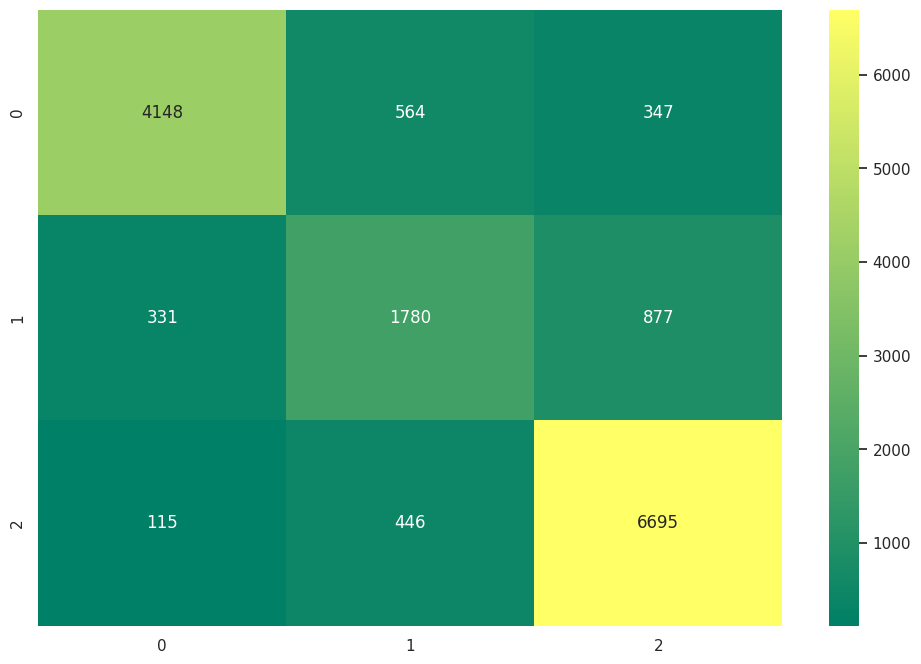

In [ ]:
model_prediction(RF_model, x, y, n_splits=5, random_state=42)

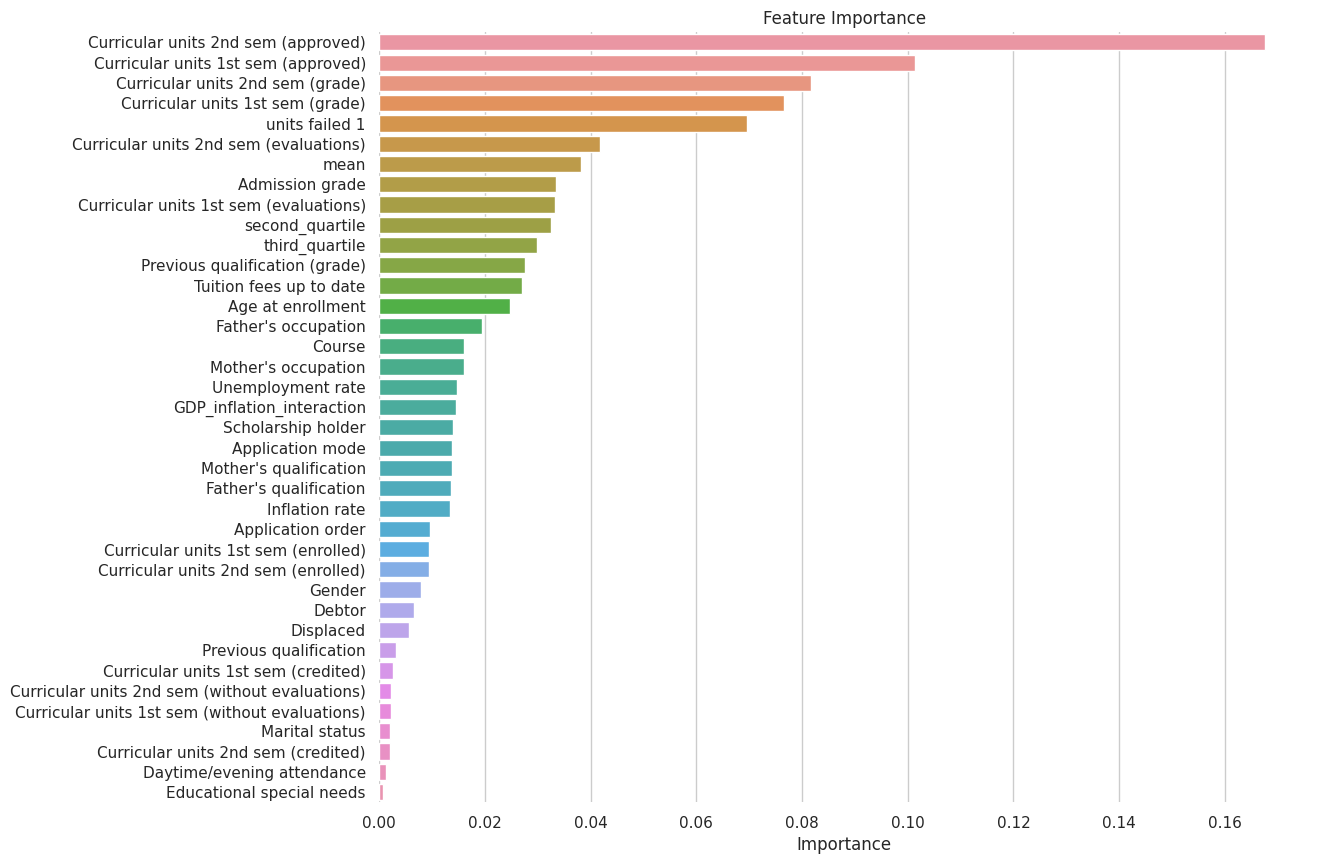

In [ ]:
# feature importances
feature_importance = RF_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()


## **8. Ada Boost**

In [ ]:
AdaBoostClassifier_model = AdaBoostClassifier()


------------------------------------------------------------------------
Mean Accuracy_Score of AdaBoostClassifier() model on Training Data is: 82.08885431423376
Mean Accuracy_Score of AdaBoostClassifier() model on Testing Data is: 81.98463045095107
Mean Precision Score of AdaBoostClassifier() model is: 0.8183184459965952
Mean Recall Score of AdaBoostClassifier() model is: 0.8198463045095107
Mean f1 Score of AdaBoostClassifier() model is: 0.8177235486286472

------------------------------------------------------------------------
Classification Report of AdaBoostClassifier() model is:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      5059
           1       0.63      0.59      0.61      2988
           2       0.85      0.92      0.88      7256

    accuracy                           0.82     15303
   macro avg       0.79      0.78      0.78     15303
weighted avg       0.82      0.82      0.82     15303


-------------------------

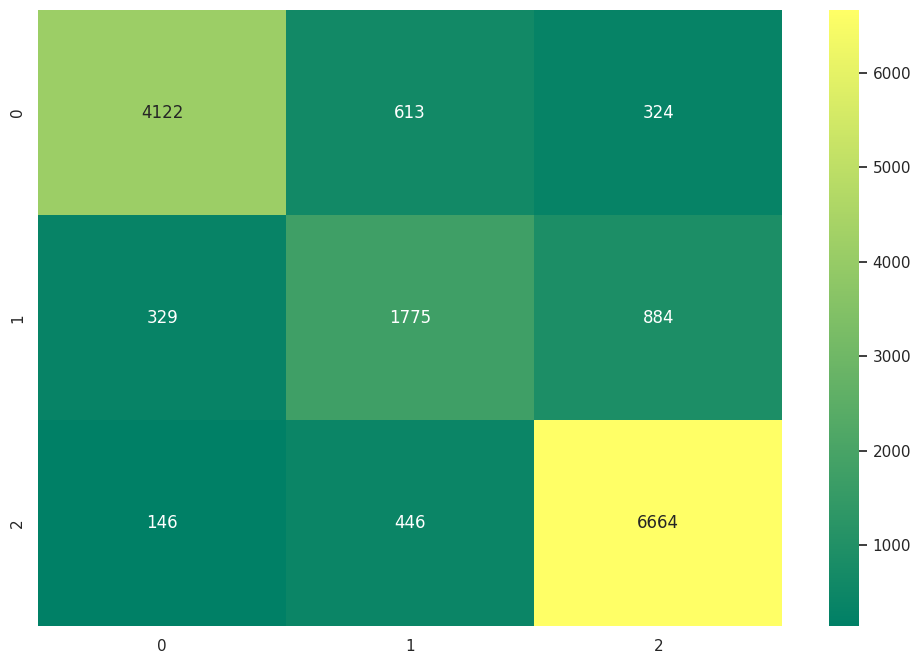

In [ ]:
model_prediction(AdaBoostClassifier_model, x, y, n_splits=5, random_state=42)

In [ ]:
# feature importances
feature_importance = AdaBoostClassifier_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()


## **9. GradientBoost**

In [ ]:
GB_model = GradientBoostingClassifier()


------------------------------------------------------------------------
Mean Accuracy_Score of GradientBoostingClassifier() model on Training Data is: 83.10952981051386
Mean Accuracy_Score of GradientBoostingClassifier() model on Testing Data is: 82.73216708154796
Mean Precision Score of GradientBoostingClassifier() model is: 0.8260072742365827
Mean Recall Score of GradientBoostingClassifier() model is: 0.8273216708154795
Mean f1 Score of GradientBoostingClassifier() model is: 0.8253505970488252

------------------------------------------------------------------------
Classification Report of GradientBoostingClassifier() model is:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      5059
           1       0.64      0.61      0.62      2988
           2       0.85      0.92      0.88      7256

    accuracy                           0.83     15303
   macro avg       0.80      0.79      0.79     15303
weighted avg       0.83      0.83

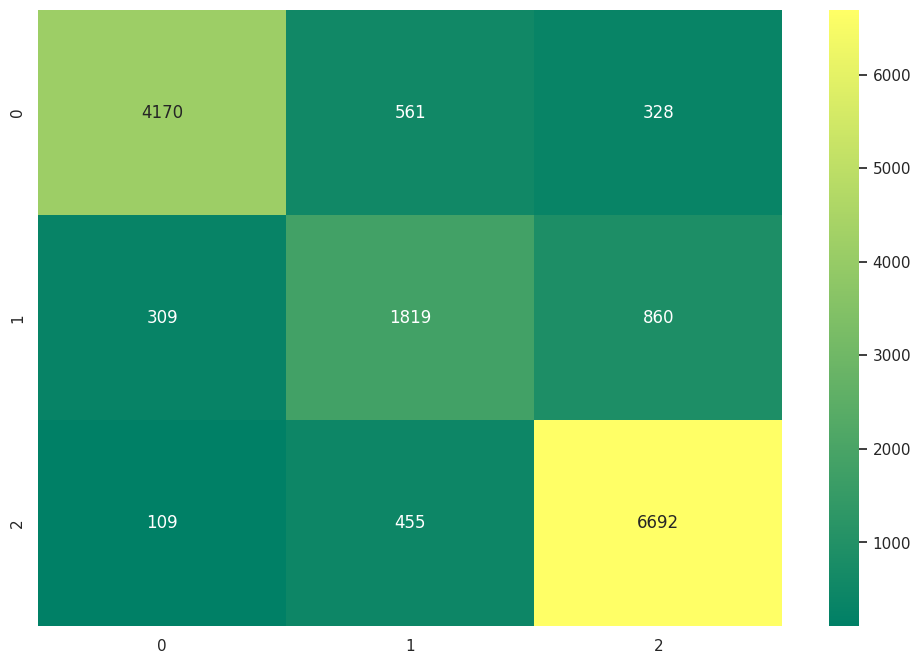

In [ ]:
model_prediction(GB_model, x, y, n_splits=5, random_state=42)

In [ ]:
# feature importances
feature_importance = GB_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()


## **10. XG Boost**

In [ ]:
XGBClassifier_model = XGBClassifier()

In [ ]:
model_prediction(XGBClassifier_model, x, y, n_splits=5, random_state=42)

In [ ]:
# feature importances
feature_importance = XGBClassifier_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()


## **11. CatBoost**

In [ ]:
CatBoost_model = CatBoostClassifier()

Выходные данные были обрезаны до нескольких последних строк (5000).
27:	learn: 0.4838243	total: 1.55s	remaining: 54s
28:	learn: 0.4815532	total: 1.61s	remaining: 54s
29:	learn: 0.4789825	total: 1.66s	remaining: 53.7s
30:	learn: 0.4772294	total: 1.71s	remaining: 53.5s
31:	learn: 0.4754491	total: 1.77s	remaining: 53.7s
32:	learn: 0.4735661	total: 1.83s	remaining: 53.5s
33:	learn: 0.4722702	total: 1.88s	remaining: 53.4s
34:	learn: 0.4706102	total: 1.93s	remaining: 53.3s
35:	learn: 0.4694036	total: 1.98s	remaining: 53.1s
36:	learn: 0.4681476	total: 2.03s	remaining: 52.9s
37:	learn: 0.4670933	total: 2.08s	remaining: 52.8s
38:	learn: 0.4658743	total: 2.14s	remaining: 52.6s
39:	learn: 0.4652258	total: 2.18s	remaining: 52.4s
40:	learn: 0.4640917	total: 2.23s	remaining: 52.2s
41:	learn: 0.4629493	total: 2.28s	remaining: 52s
42:	learn: 0.4620356	total: 2.33s	remaining: 51.9s
43:	learn: 0.4612704	total: 2.38s	remaining: 51.8s
44:	learn: 0.4605632	total: 2.44s	remaining: 51.7s
45:	learn: 0.4599797

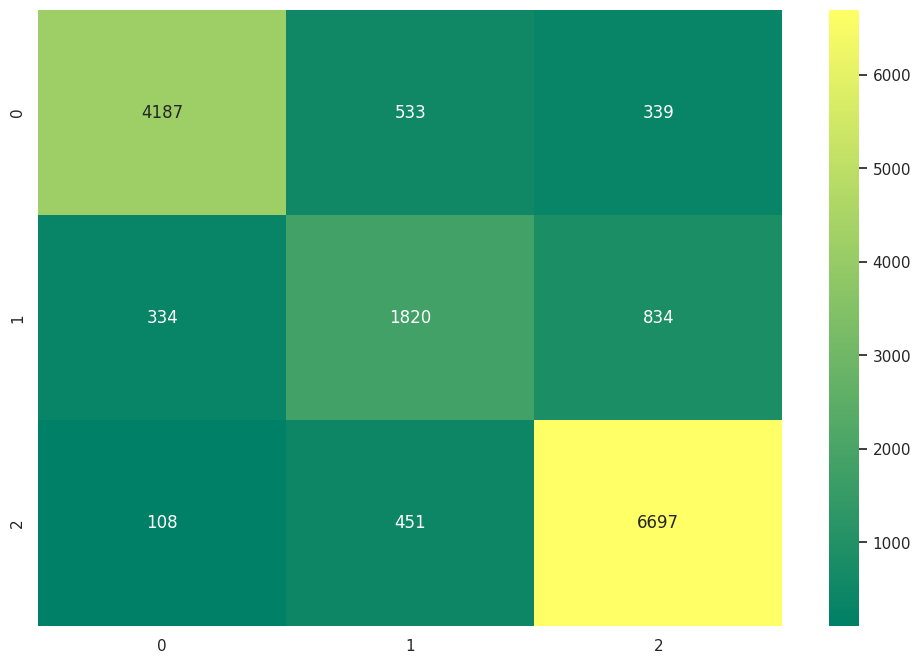

In [ ]:
model_prediction(CatBoost_model, x, y, n_splits=5, random_state=42)

In [ ]:
# feature importances
feature_importance = CatBoost_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()


## **12. LGBM**

In [ ]:
LGBM_model =  LGBMClassifier()

In [ ]:
model_prediction(LGBM_model, x, y, n_splits=5, random_state=42)

In [ ]:
# feature importances
feature_importance = LGBM_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()


## **Comparing Performance**

In [ ]:
# Create a DataFrame with these accuracy scores
data = {
    'Model': ['SGD_classifer','Logistic_Regression', 'KNN','Naive_Bayes','DecisionTree','ExtraTree_Classifier','RandomForest','Adaboost','GBoost','XGBoost','catbost','LGBM'],
    'Training_Accuracy': Training_Accuracy,
    'Testing_Accuracy': Testing_Accuracy
}
Acc_df = pd.DataFrame(data)

In [ ]:
# Sort by Testing_Accuracy
Acc_df = Acc_df.sort_values(by='Testing_Accuracy', ascending=False).reset_index(drop=True)

Acc_df

Model  Training_Accuracy  Testing_Accuracy
0                catbost          86.425090         83.078489
1                   LGBM          85.209362         83.074570
2                XGBoost          88.539298         83.019679
3                 GBoost          83.109530         82.732167
4           RandomForest          99.998693         82.506072
5   ExtraTree_Classifier         100.000000         82.159749
6               Adaboost          82.088854         81.984630
7    Logistic_Regression          81.602041         81.538985
8          SGD_classifer          80.292544         80.224262
9                    KNN          83.951815         77.819601
10          DecisionTree         100.000000         74.156408
11           Naive_Bayes          73.062220         73.002441

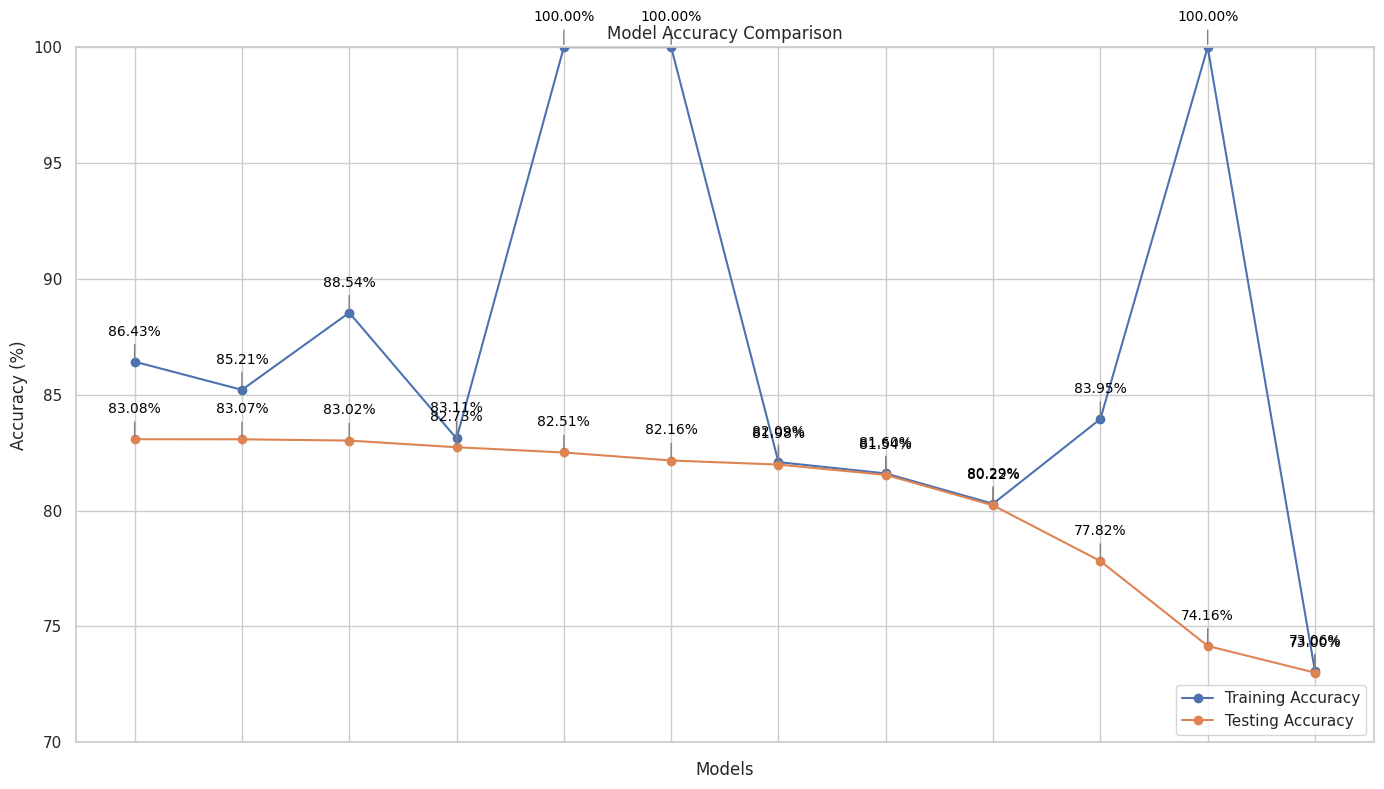

In [ ]:
# Plot the DataFrame
fig, ax = plt.subplots(figsize=(14, 8))
Acc_df.plot(x='Model', y=['Training_Accuracy', 'Testing_Accuracy'], marker='o', linestyle='-', ax=ax)

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy Comparison')
ax.set_ylim(70, 100)

# Annotate training accuracy
for i, accuracy in enumerate(Acc_df['Training_Accuracy']):
    ax.annotate(f'{accuracy:.2f}%', xy=(i, accuracy), xytext=(i, accuracy + 1),
                ha='center', va='bottom', fontsize=10, color='black',
                arrowprops=dict(arrowstyle='-', color='gray'))

# Annotate testing accuracy
for i, accuracy in enumerate(Acc_df['Testing_Accuracy']):
    ax.annotate(f'{accuracy:.2f}%', xy=(i, accuracy), xytext=(i, accuracy + 1),
                ha='center', va='bottom', fontsize=10, color='black',
                arrowprops=dict(arrowstyle='-', color='gray'))

# Remove model names from x-axis
ax.set_xticks(range(len(Acc_df['Model'])))
ax.set_xticklabels([''] * len(ax.get_xticks()))

# Show the plot
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='lower right')
plt.xticks(rotation=45, ha='right')
plt.grid(True)

# Adjust layout to make room for the rotated x-axis labels
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()



# 6 | Hypertuning the selected model





## **1. Hypertung XGBoost**

In [ ]:
'''
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 6, 13)
    n_estimators = trial.suggest_int('n_estimators', 500, 5000)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)

    print('Training the model with', x_train.shape[1], 'features')

    params = {
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'gamma': gamma,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'eval_metric': 'mlogloss'
    }

    clf = XGBClassifier(**params,class_weight = class_weights_dict)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(clf, x, y, cv=5, scoring='accuracy')

    validation_score = np.mean(cv_results['test_score'])

    return validation_score'''

In [ ]:
#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=30)

In [ ]:
#best_params = study.best_params
#print("Best Hyperparameters:", best_params)

In [79]:
best_params = {'max_depth': 6, 'n_estimators': 4937, 'gamma': 0.8644097106882519, 'reg_alpha': 0.4215206295140813, 'reg_lambda': 0.6203345757486959, 'min_child_weight': 9, 'subsample': 0.8694499955731673, 'colsample_bytree': 0.5841425315961482, 'learning_rate': 0.02302515234749565}
# 87.95804382669048 and 83.16572172702416

In [80]:
# Now you can use the best_params to train the final model
hypertuned_XGB_Model = XGBClassifier(**best_params, eval_metric='mlogloss', num_class=3)

In [ ]:
model_prediction(hypertuned_XGB_Model, x, y, n_splits=5, random_state=42)

In [ ]:
# feature importances
feature_importance = hypertuned_XGB_Model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()


## **2. Hypertung Catboost**

In [ ]:
'''# Define the objective function for Optuna
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-2, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.01, 100.00, log=True),
        'od_type': 'Iter',
        'od_wait': trial.suggest_int('od_wait', 10, 50)
    }

    # Initialize the CatBoost classifier with hyperparameters
    clf = CatBoostClassifier(**param, verbose=0)

    # Cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_results = cross_validate(clf, x, y, cv=cv, scoring='accuracy', n_jobs=-1, return_estimator=True)

    # Calculate the mean validation score
    validation_score = np.mean(cv_results['test_score'])

    return validation_score'''

In [ ]:
# Set up Optuna study
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=20)

In [ ]:
# Get the best hyperparameters
#best_params = study.best_params
#print("Best Hyperparameters :", best_params)

In [82]:
best_params = {'iterations': 713, 'depth': 6, 'learning_rate': 0.0966120526714887, 'l2_leaf_reg': 0.061010894132361757, 'border_count': 248, 'random_strength': 0.011241881636142037, 'bagging_temperature': 0.014862947689211698, 'od_wait': 22}

In [83]:
hypertuned_cb_model = CatBoostClassifier(**best_params)

In [ ]:
model_prediction(hypertuned_cb_model, x, y, n_splits=5, random_state=42)

In [86]:
import pickle


In [103]:
with open('stacking_xgb_lgbm.pkl', 'wb') as f:
    pickle.dump(stacking_xgb_lgbm, f)


In [ ]:
# feature importances
feature_importance = hypertuned_cb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()


## **3. Hypertung LGBM**

In [ ]:
'''def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15)
    }


    clf = LGBMClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(clf, x, y, cv=cv, scoring='accuracy', n_jobs=-1)

    validation_score = np.mean(cv_results['test_score'])

    return validation_score'''

In [ ]:
# Set up Optuna study
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=200)

In [ ]:
# Get the best hyperparameters
#best_params = study.best_params
#print("Best Hyperparameters for y:", best_params)

In [95]:
best_params = {
    'objective': 'multiclass',
    'boosting_type': 'goss',  # Gradient-based One-Side Sampling (GOSS)
    'tree_learner': 'feature',
    'n_estimators': 743,
    'learning_rate': 0.02636616162598401,
    'num_leaves': 699,
    'max_depth': 8,
    'colsample_bytree': 0.7975468653525116,
    'min_child_samples': 102,
    'min_data_in_leaf': 5,  # min_sum_hessian_in_leaf seems to be replaced with min_data_in_leaf in newer versions
    'min_split_gain': 0.7247318987185962,
    'max_bin': 156,
    'top_rate': 0.6132659772851583,
    'verbose': -1,
    'random_state': 42,
}
#Achieved train 88.68356334120548 and  test 83.13236452350763

In [96]:
hypertuned_LGBM_model = LGBMClassifier(**best_params)

In [ ]:
model_prediction(hypertuned_LGBM_model, x, y, n_splits=5, random_state=42)

In [ ]:
# feature importances
feature_importance = hypertuned_LGBM_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()


## **Comparing Performance**

In [ ]:
# Create a DataFrame with these accuracy scores
data = {
    'Model': ['SGD_classifer','Logistic_Regression', 'KNN','Naive_Bayes','DecisionTree','ExtraTree_Classifier','RandomForest','Adaboost','GBoost','XGBoost','catbost','LGBM','hypertuned_XGB_Model','hypertuned_cb_model','hypertuned_LGBM_model'],
    'Training_Accuracy': Training_Accuracy,
    'Testing_Accuracy': Testing_Accuracy
}
Acc_df = pd.DataFrame(data)

In [ ]:
# Sort by Testing_Accuracy
Acc_df = Acc_df.sort_values(by='Testing_Accuracy', ascending=False).reset_index(drop=True)

Acc_df

Model  Training_Accuracy  Testing_Accuracy
0    hypertuned_XGB_Model          88.037128         83.273216
1   hypertuned_LGBM_model          88.816357         83.205256
2     hypertuned_cb_model          87.477456         83.096784
3                 catbost          86.425090         83.078489
4                    LGBM          85.209362         83.074570
5                 XGBoost          88.539298         83.019679
6                  GBoost          83.109530         82.732167
7            RandomForest          99.998693         82.506072
8    ExtraTree_Classifier         100.000000         82.159749
9                Adaboost          82.088854         81.984630
10    Logistic_Regression          81.602041         81.538985
11          SGD_classifer          80.292544         80.224262
12                    KNN          83.951815         77.819601
13           DecisionTree         100.000000         74.156408
14            Naive_Bayes          73.062220         73.002441

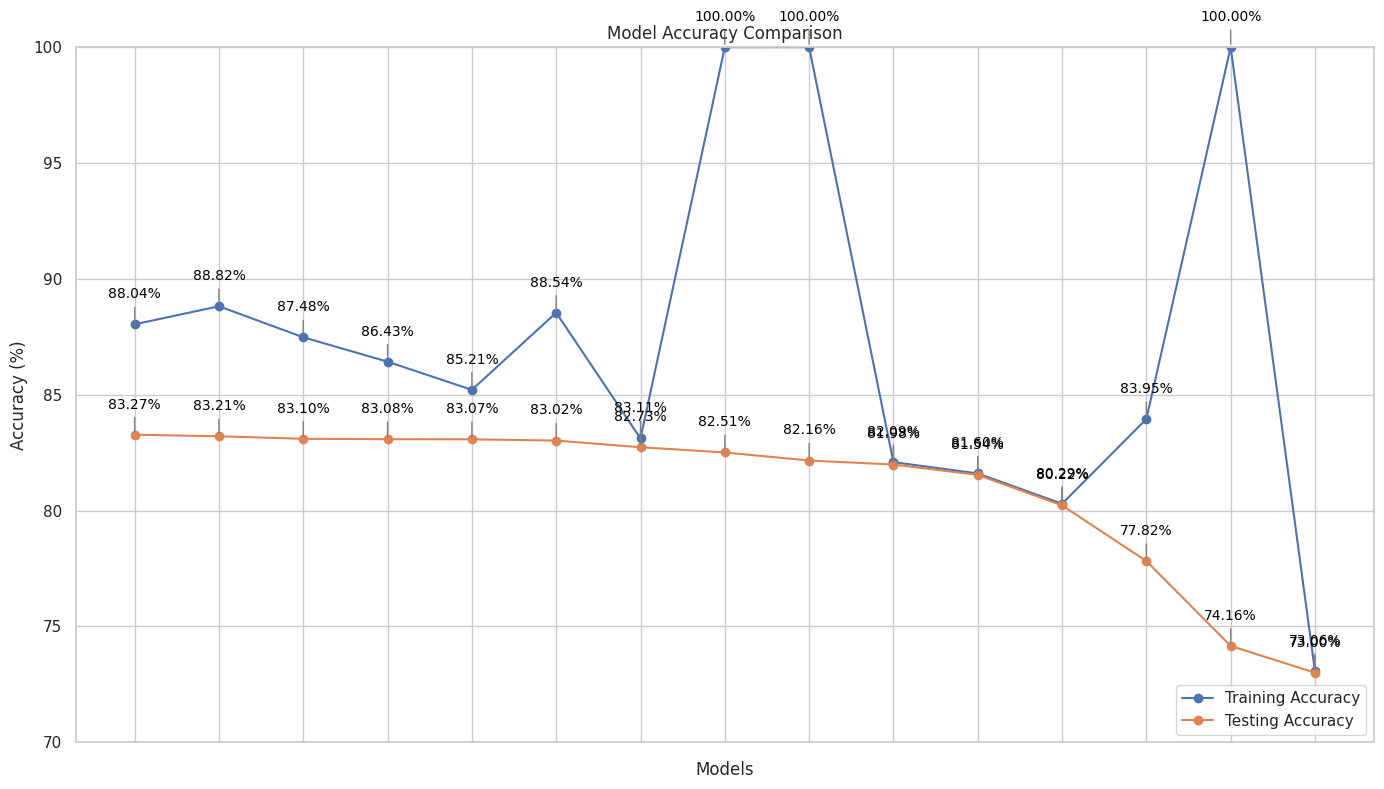

In [ ]:
# Plot the DataFrame
fig, ax = plt.subplots(figsize=(14, 8))
Acc_df.plot(x='Model', y=['Training_Accuracy', 'Testing_Accuracy'], marker='o', linestyle='-', ax=ax)

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy Comparison')
ax.set_ylim(70, 100)

# Annotate training accuracy
for i, accuracy in enumerate(Acc_df['Training_Accuracy']):
    ax.annotate(f'{accuracy:.2f}%', xy=(i, accuracy), xytext=(i, accuracy + 1),
                ha='center', va='bottom', fontsize=10, color='black',
                arrowprops=dict(arrowstyle='-', color='gray'))

# Annotate testing accuracy
for i, accuracy in enumerate(Acc_df['Testing_Accuracy']):
    ax.annotate(f'{accuracy:.2f}%', xy=(i, accuracy), xytext=(i, accuracy + 1),
                ha='center', va='bottom', fontsize=10, color='black',
                arrowprops=dict(arrowstyle='-', color='gray'))

# Remove model names from x-axis
ax.set_xticks(range(len(Acc_df['Model'])))
ax.set_xticklabels([''] * len(ax.get_xticks()))

# Show the plot
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='lower right')
plt.xticks(rotation=45, ha='right')
plt.grid(True)

# Adjust layout to make room for the rotated x-axis labels
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()



# 7 | Model Blending




<a id='7.1'></a>
## **1. Stacking Classifier (XGB+LGBM)**

In [100]:
# Define the list of estimators
estimators = [('xgb', hypertuned_XGB_Model),('lgbm', hypertuned_LGBM_model)]

# Initialize the StackingClassifier with Random Forest as final estimator
stacking_xgb_lgbm = StackingClassifier(estimators=estimators,final_estimator=LGBMClassifier(), passthrough=True)

In [101]:
stacking_xgb_lgbm

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5841425315961482,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None,
                                              gamma=0.8644097106882519,
                                              grow_policy=None,
                                              importance_type=None,
                                              inte...
                                               colsample_bytree=0.7975468653525116,
                                               learning_rate=0.02636616162598401,
                                               max_bin=156, max_depth=8,
                                               min_child_samples=102,
                                               min_data_in_leaf=5,
                                               min_split_gain=0.7247318987185962,
                                               n_estimators=743, num_leaves=699,
                                               objective='multiclass',
                                               random_state=42,
                                               top_rate=0.6132659772851583,
                                               tree_learner='feature',
                                               verbose=-1))],
                   final_estimator=LGBMClassifier(), passthrough=True)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3572
[LightGBM] [Info] Number of data points in the train set: 64753, number of used features: 46
[LightGBM] [Info] Start training from score -1.108405
[LightGBM] [Info] Start training from score -1.637915
[LightGBM] [Info] Start training from score -0.743325
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3565
[LightGBM] [Info] Number of data points in the train set: 64753, number of used features: 46
[LightGBM] [Info] Start training from score -1.108452
[LightGBM] [Info] Start training from score -1.637915
[LightGBM] [Info] Start 

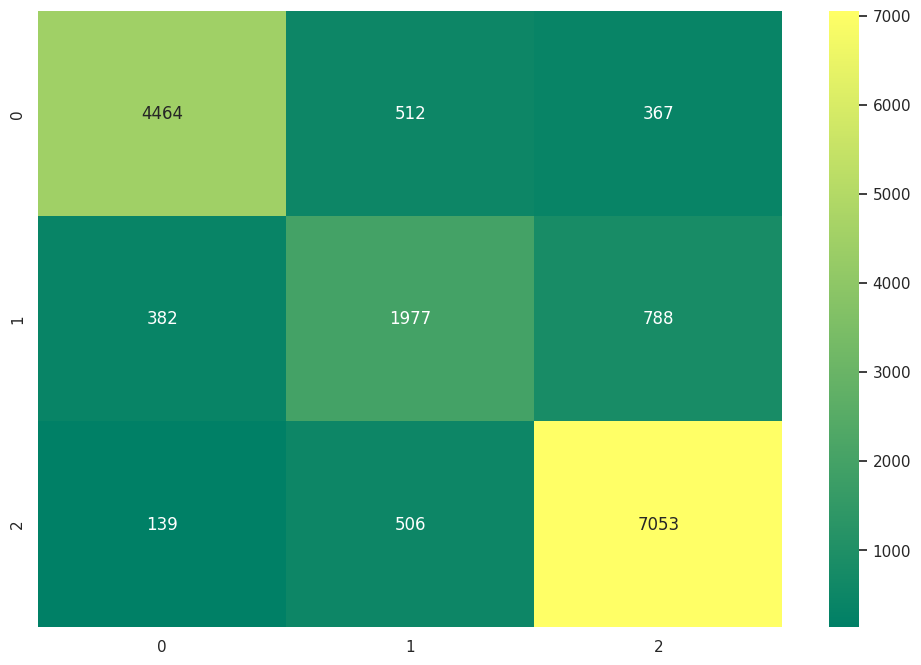

In [102]:
# Fit the stacking classifier on the training data
model_prediction(stacking_xgb_lgbm, x, y, n_splits=5, random_state=42)

<a id='7.2'></a>
## **2. Stacking Classifier (Catboost+XGB)**

In [90]:
estimators = [('catboost', hypertuned_cb_model),('xgb', hypertuned_XGB_Model)]

stacking_cat_xgb = StackingClassifier(estimators=estimators,final_estimator=LGBMClassifier(),passthrough=True)

In [158]:
stacking_cat_xgb

StackingClassifier(estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x7bdb85f16800>),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5841425315961482,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=No...
                                              interaction_constraints=None,
                                              learning_rate=0.02302515234749565,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=9, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=4937, n_jobs=None,
                                              num_class=3,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LGBMClassifier(), passthrough=True)

In [ ]:
# Fit the stacking classifier on the training data
model_prediction(stacking_cat_xgb, x, y, n_splits=5, random_state=42)

<a id='7.3'></a>
## **3. Voting Ensemble**

In [4]:
import pickle

In [8]:
with open('/kaggle/input/ensemble/scikitlearn/default/1/hypertuned_XGB_Model.pkl', 'rb') as f:
    hypertuned_XGB_Model = pickle.load(f)
with open('/kaggle/input/ensemble/scikitlearn/default/1/stacking_xgb_lgbm.pkl', 'rb') as f:
    stacking_xgb_lgbm = pickle.load(f)
with open('/kaggle/input/ensemble/scikitlearn/default/1/stacking_cat_xgb.pkl', 'rb') as f:
    stacking_cat_xgb = pickle.load(f)


In [65]:
# Train an Ensemble model using a combination of the GBoost and adaboost Classifiers
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', hypertuned_XGB_Model),
        ('stacking1', stacking_xgb_lgbm),
        ('stacking2',stacking_cat_xgb)
    ],
    voting='soft',
    flatten_transform=True
)

In [ ]:
# Fit the stacking classifier on the training data
model_prediction(ensemble_model, x, y, n_splits=5, random_state=42)


## **Comparing Performance**

In [ ]:
# Create a DataFrame with these accuracy scores
data = {
    'Model': ['SGD_classifer','Logistic_Regression', 'KNN','Naive_Bayes','DecisionTree','ExtraTree_Classifier','RandomForest','Adaboost','GBoost','XGBoost','catbost','LGBM','hypertuned_XGB_Model','hypertuned_cb_model','hypertuned_LGBM_model','stacking_xgb_lgbm','stacking_cat_xgb','ensemble_model'],
    'Training_Accuracy': Training_Accuracy,
    'Testing_Accuracy': Testing_Accuracy
}
Acc_df = pd.DataFrame(data)

NameError: name 'Training_Accuracy' is not defined

In [ ]:
# Sort by Testing_Accuracy
Acc_df = Acc_df.sort_values(by='Testing_Accuracy', ascending=False).reset_index(drop=True)

Acc_df

NameError: name 'Acc_df' is not defined

In [ ]:
# Plot the DataFrame
fig, ax = plt.subplots(figsize=(14, 8))
Acc_df.plot(x='Model', y=['Training_Accuracy', 'Testing_Accuracy'], marker='o', linestyle='-', ax=ax)

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy Comparison')
ax.set_ylim(70, 100)

# Annotate training accuracy
for i, accuracy in enumerate(Acc_df['Training_Accuracy']):
    ax.annotate(f'{accuracy:.2f}%', xy=(i, accuracy), xytext=(i, accuracy + 1),
                ha='center', va='bottom', fontsize=10, color='black',
                arrowprops=dict(arrowstyle='-', color='gray'))

# Annotate testing accuracy
for i, accuracy in enumerate(Acc_df['Testing_Accuracy']):
    ax.annotate(f'{accuracy:.2f}%', xy=(i, accuracy), xytext=(i, accuracy + 1),
                ha='center', va='bottom', fontsize=10, color='black',
                arrowprops=dict(arrowstyle='-', color='gray'))

# Remove model names from x-axis
ax.set_xticks(range(len(Acc_df['Model'])))
ax.set_xticklabels([''] * len(ax.get_xticks()))

# Show the plot
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='lower right')
plt.xticks(rotation=45, ha='right')
plt.grid(True)

# Adjust layout to make room for the rotated x-axis labels
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()



# 8 | Preparing Submission



In [ ]:
models_to_evaluate = [
    ("hypertuned_cb_model", hypertuned_cb_model),
    ("hypertuned_XGB_Model", hypertuned_XGB_Model),
    ("hypertuned_LGBM_model", hypertuned_LGBM_model),
    ("LGBM_model", LGBM_model),
    ("CatBoost_model", CatBoost_model),
    ("XGBClassifier_model", XGBClassifier_model),
    ("stacking_xgb_lgbm",stacking_xgb_lgbm),
    ("stacking_cat_xgb",stacking_cat_xgb),
    # ("ensemble_model",ensemble_model)
]
for model_name, model in models_to_evaluate:
    y_pred = model.predict(test_df)
    y_pred = label_encoder.inverse_transform(y_pred)
    submission = pd.DataFrame({"id": id, "Target": y_pred})
    submission.to_csv(f"{model_name}.csv", index=False)


In [67]:
models_to_evaluate = [ ("ensemble_model",ensemble_model)]
for model_name, model in models_to_evaluate:
    y_pred = model.predict(test_df)
    y_pred = label_encoder.inverse_transform(y_pred)
    submission = pd.DataFrame({"id": id, "Target": y_pred})
    submission.to_csv(f"{model_name}.csv", index=False)

In [ ]:
with open('xgboost_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
